## Olivetti Faces — Unsupervised and Semi-Supervised Learning (Chapter 8)

### 1️⃣Overview

In this notebook, I study and apply the concepts from **Chapter 8: Unsupervised Learning Techniques** of *Hands-On Machine Learning with Scikit-Learn and PyTorch*, using the **Olivetti Faces dataset** as a unified experimental setting.

The notebook is built around **Exercises 10–13** from the end of the chapter and is structured as a small, self-contained project rather than a collection of isolated experiments. The goal is to move beyond theoretical descriptions and develop a practical, implementation-oriented understanding of unsupervised and semi-supervised learning methods.

---

### What This Project Is About

This project explores how unsupervised learning techniques can be used to:

- Discover structure in high-dimensional image data
- Learn useful representations without explicit labels
- Improve supervised learning through feature transformation
- Model data distributions for generation and anomaly detection

All experiments are conducted on the same dataset to ensure consistency and to highlight how different techniques complement each other.

---

### Chapter and Exercises Covered

This notebook focuses on the following parts of **Chapter 8**:

- Clustering algorithms (with emphasis on k-means)
- Dimensionality reduction techniques
- Gaussian Mixture Models
- Anomaly and novelty detection

Specifically, it implements and analyzes **Exercises 10–13** from the chapter.

---

### What Will Be Demonstrated

The notebook demonstrates the following concepts in practice:

- **Clustering**
  - k-means clustering on high-dimensional face images
  - Choosing the number of clusters using inertia and silhouette score
  - Visual inspection of cluster contents

- **Dimensionality Reduction**
  - Using k-means as a feature transformation method
  - Applying PCA to reduce dimensionality while preserving variance

- **Gaussian Mixture Models**
  - Training GMMs in reduced-dimensional space
  - Generating new face-like images
  - Using probabilistic density estimates

- **Anomaly Detection**
  - Detecting anomalies using GMM likelihood scores
  - Detecting anomalies using PCA reconstruction error
  - Comparing normal and artificially modified images

---

### Goal of This Notebook

The goal of this notebook is to demonstrate a **clear, end-to-end understanding** of unsupervised learning techniques by combining theory, implementation, and empirical evaluation, in a form suitable for a professional machine learning portfolio

### 2️⃣ Imports + Global Configuration

In [1]:
import sys

assert sys.version_info >= (3, 10) 

from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.datasets import fetch_olivetti_faces


from sklearn.cluster import (
    KMeans,
    MiniBatchKMeans,
    DBSCAN,
    MeanShift,
    estimate_bandwidth,
    Birch
)

from sklearn.mixture import (
    GaussianMixture,
    BayesianGaussianMixture
)


from sklearn.decomposition import PCA

from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix,
    classification_report, 
    accuracy_score

)

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LogisticRegression

from sklearn.semi_supervised import (
    LabelPropagation,
    LabelSpreading
)

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score, 
    StratifiedShuffleSplit
)

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### 3️⃣ Load the Dataset

In [4]:
olivetti = fetch_olivetti_faces(shuffle=True, random_state=RANDOM_STATE)

In [5]:
print(olivetti.DESCR) 

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [6]:
X = olivetti.data
images = olivetti.images
y = olivetti.target # Person IDs 40 classes

print("X shapes: number_of_samples, number_of_features", X.shape) 
print("Image shapes:", images.shape)
print("y shapes:", y.shape)
print("Number of unique classes", len(np.unique(y)))

X shapes: number_of_samples, number_of_features (400, 4096)
Image shapes: (400, 64, 64)
y shapes: (400,)
Number of unique classes 40


In [7]:
olivetti.target

array([20, 28,  3, 21,  9,  8, 32,  9, 26, 12,  0, 36,  5,  7, 13,  4, 27,
       37, 23, 38,  7,  1, 39, 27,  0, 39, 11, 22, 26, 10, 39, 19, 26,  5,
       23, 11, 11, 34, 15, 14, 38,  5,  7,  2,  8, 38, 14, 18,  2, 17,  4,
       32, 33,  7, 37,  3, 22, 17,  3, 15, 12, 29, 25,  7, 10,  3, 35, 26,
       39,  7, 32, 14,  0,  4, 38, 24, 22, 36, 17, 28,  0,  1, 20, 25, 27,
        6, 24, 30, 10,  9, 23, 33, 11, 22, 18, 31, 37, 38, 23,  7, 24, 11,
        1,  6, 15,  0,  1, 13, 35, 34, 13, 38, 29, 38, 29,  6,  7, 28, 30,
       28, 15, 10,  1, 34,  2, 17, 35, 33, 16, 24, 31, 14, 25, 17, 11, 19,
       22, 26, 21, 30,  3, 13, 29, 15, 19, 28,  5, 11, 16, 36,  0, 33, 27,
       15,  1, 19, 10,  8, 31, 39, 37, 20, 28, 16, 35,  8, 37, 16, 14, 22,
        9,  6, 12,  9, 14, 32,  9, 23,  6,  2,  3, 14, 12, 18,  6, 19, 32,
       21, 31, 19, 12, 14, 37,  8, 33, 34, 33, 35, 33, 30, 18, 20, 28, 21,
       28, 12,  3,  1, 32, 18, 22, 11, 17, 32, 29, 11, 36, 27, 38, 28, 36,
       16, 25, 13, 15, 19

### 4️⃣ Train / Validation / Test Split (Stratified)

In [8]:
# 60% train 20% validation 20% test

# Why sStratifiedShuffleSplit => Each split keeps the same class proportions as the full dataset
# Wy split in two splits => Because train_test_split can only split into two parts

# We have X data for ML, images 64x64, for visualization, y labels (person ID), all the represent same sample but in differnt forms
#   => So we split all three together keeping alignment 

# Example why do we solit into three parts: study using practise problems - TRAINING, take mock exam - VALIDATION, real exam - TEST
# The validation set: is not used to fit parameters but is used to compare models

X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(
    X, y, images,
    test_size=0.4, 
    stratify=y, 
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test, images_val, images_test = train_test_split(
    X_temp, y_temp, images_temp,
    test_size=0.4, 
    stratify=y_temp, 
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (240, 4096) (240,)
Val: (96, 4096) (96,)
Test: (64, 4096) (64,)


In [9]:
def class_counts(y_split): 
    counts = Counter(y_split) 
    return min(counts.values()), max(counts.values())

print("Train:", class_counts(y_train))
print("Val:  ", class_counts(y_val))
print("Test: ", class_counts(y_test))

# Counter counts how many times each class appears in this case in y_train

Train: (6, 6)
Val:   (2, 3)
Test:  (1, 2)


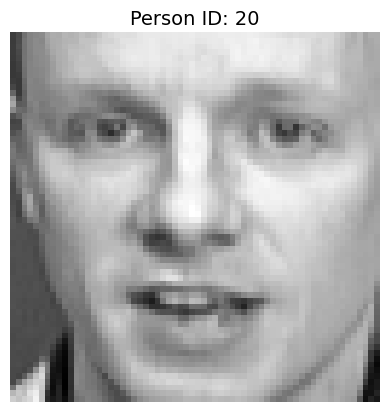

In [10]:
plt.figure()
plt.imshow(images[0], cmap="gray")
plt.title(f"Person ID: {y[0]}")
plt.axis("off")
plt.show()

### Step 5️⃣ Choose the Number of Clusters (k)

In [11]:
# Inertia = sum of squared distances from points to their assigned centroid
#   We look for an elbow point where improvement slows down
# Silhouette Score = measures how well points fit within their cluster vs other clusters
#   range[-1, 1], close to 1 -> well separated, close to 0 overlapping clusters, negative wrond assingments


k_values = range(10, 121, 10)

inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k, 
        random_state=RANDOM_STATE, 
        n_init=10
        ) 
    
    labels = kmeans.fit_predict(X_train)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, labels)) 

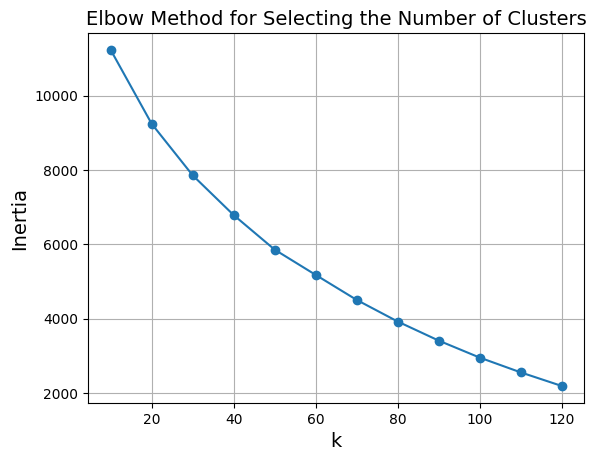

In [12]:
# Plot 1 Elbow Method 
plt.figure() 
plt.plot(k_values, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for Selecting the Number of Clusters")
plt.grid(True)
plt.show() 

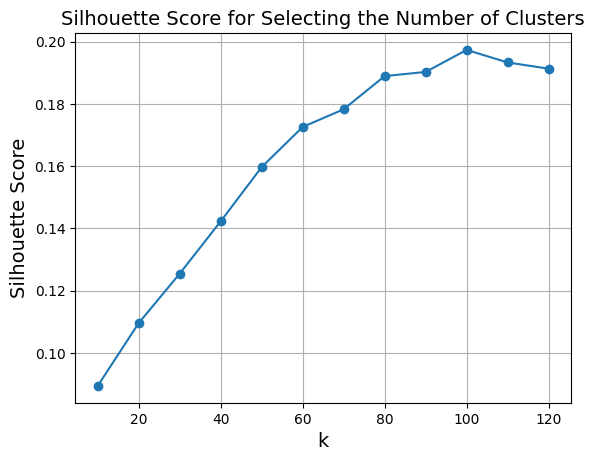

In [13]:
# Plot Silhouette Score

plt.figure() 
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score") 
plt.title("Silhouette Score for Selecting the Number of Clusters")
plt.grid(True)
plt.show() 

Based on the elbow plot, inertia shows diminishing returns beyond approximately k = 80

The silhouette score increases up to around k = 100 and then stabilizes

Therefore k = 80 or k = 100 represents a reasonable trade-off between compactness and separation and is chosen for subsequent experiments 

### Step 7️⃣ Visualize Clusters

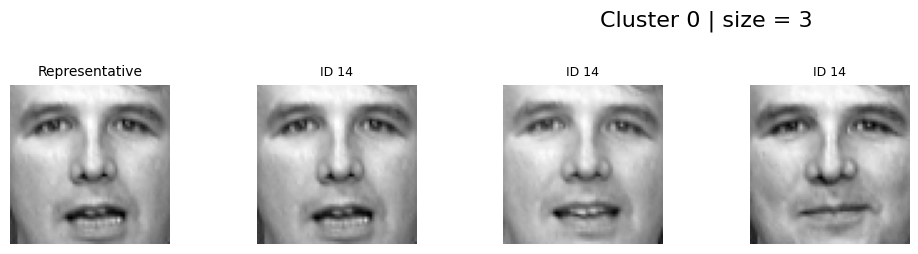

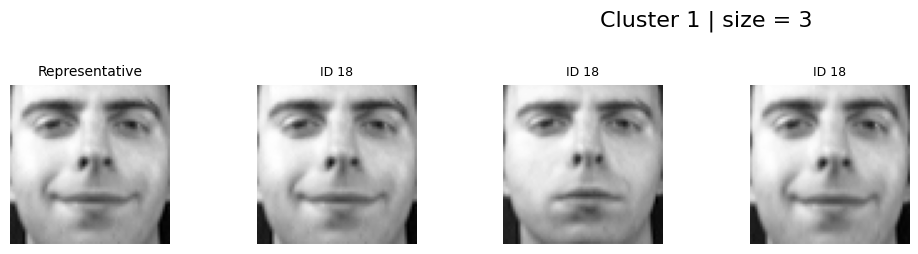

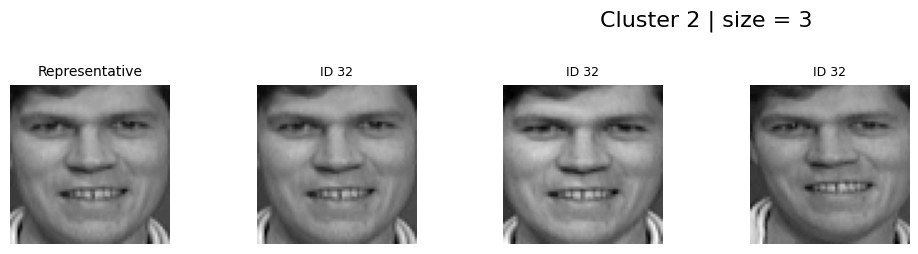

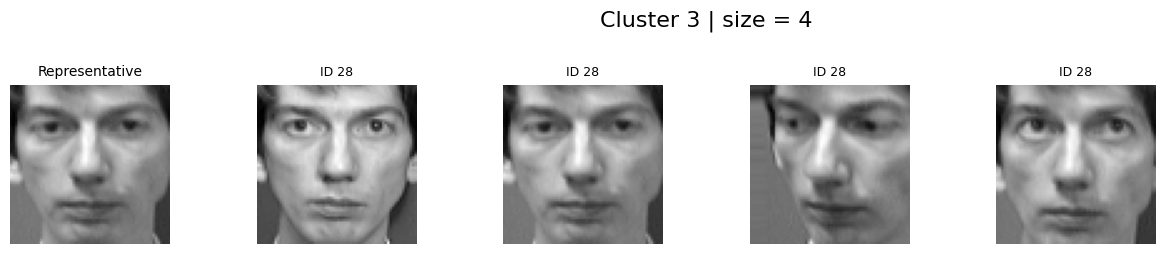

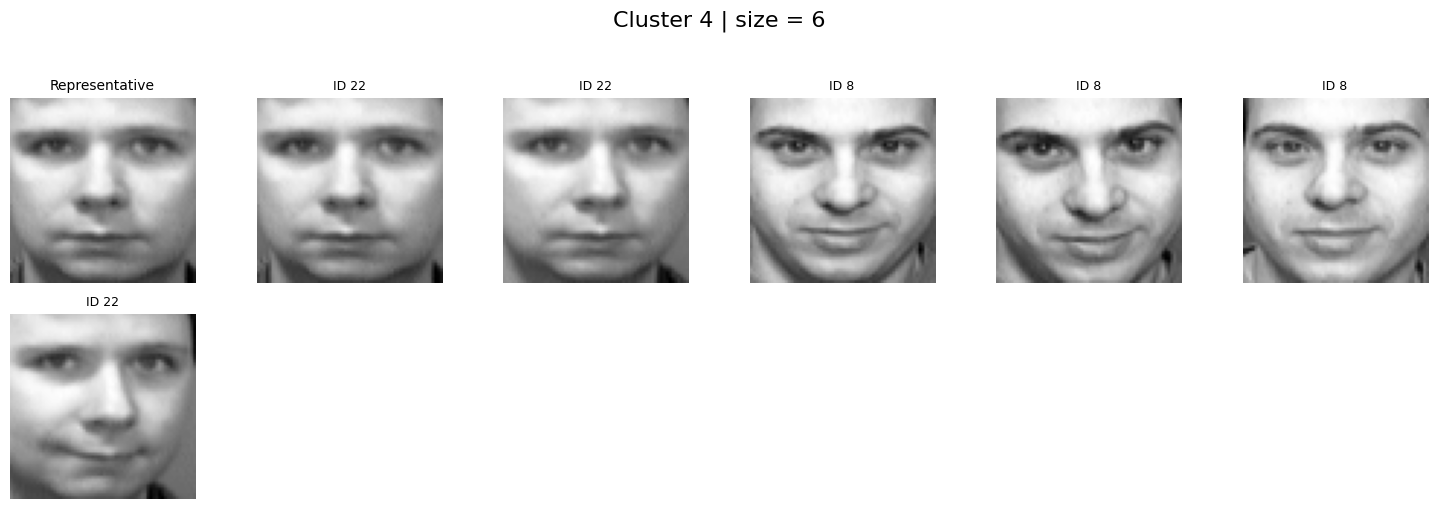

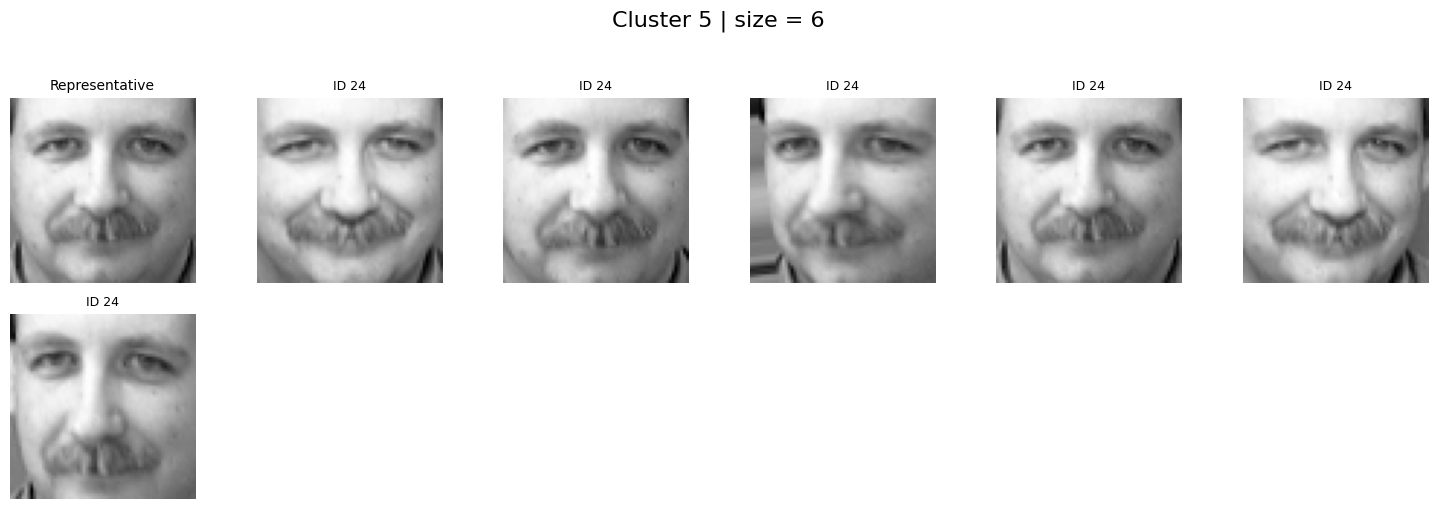

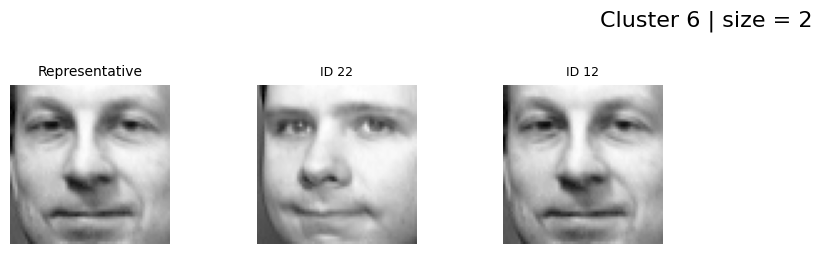

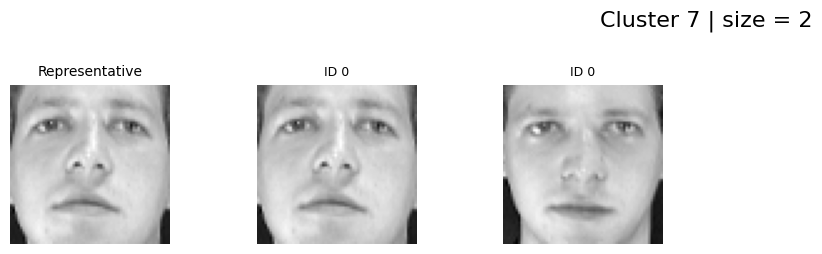

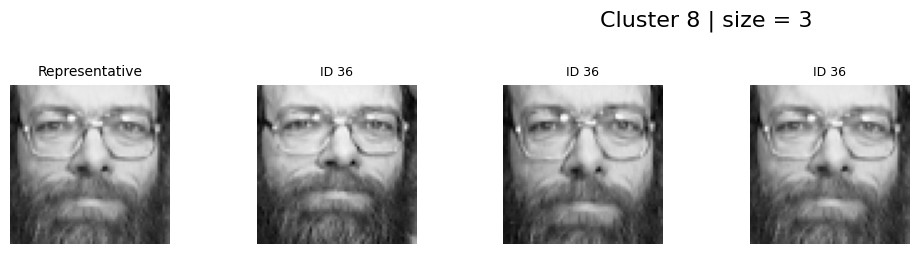

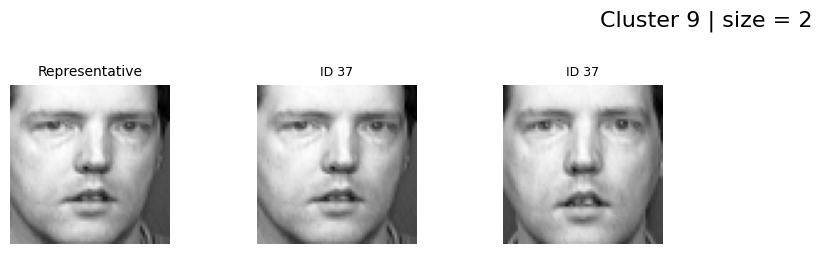

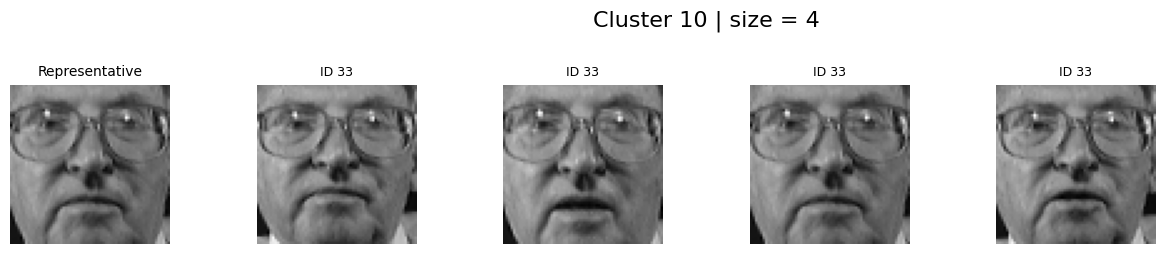

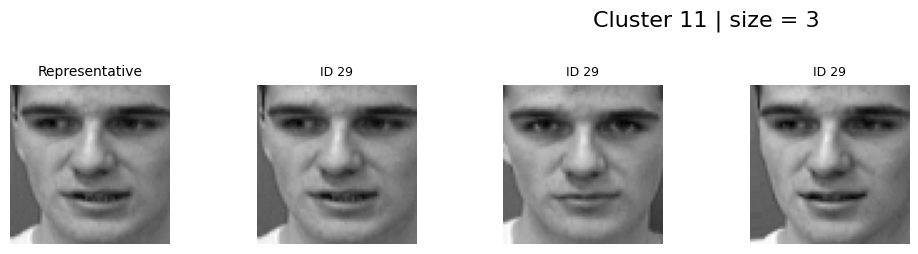

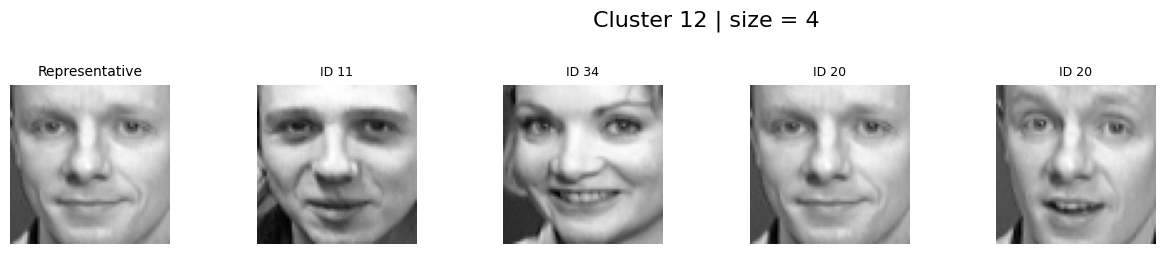

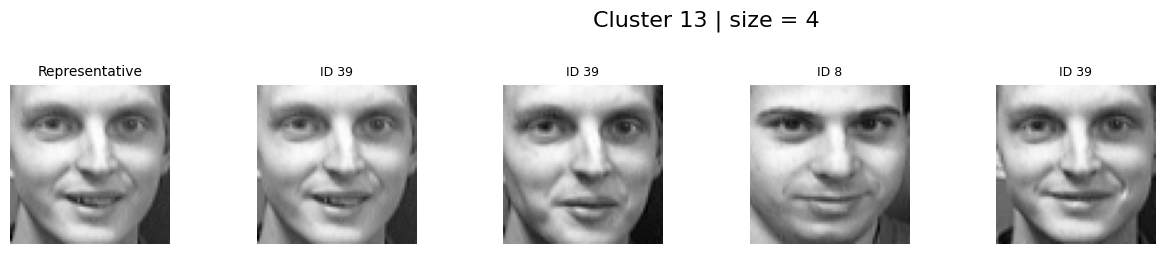

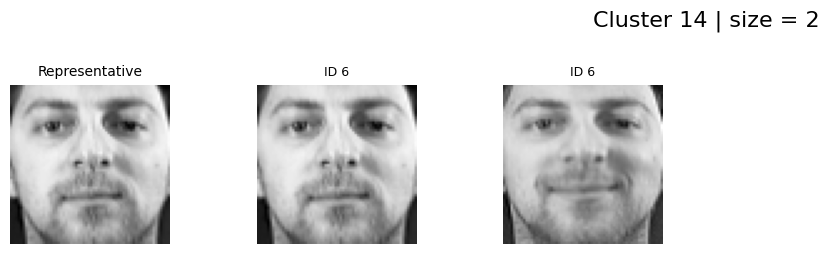

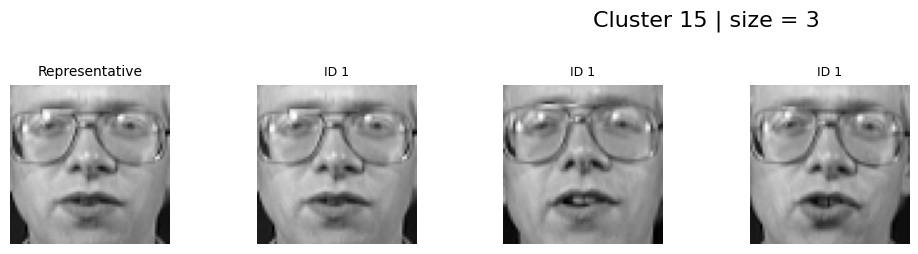

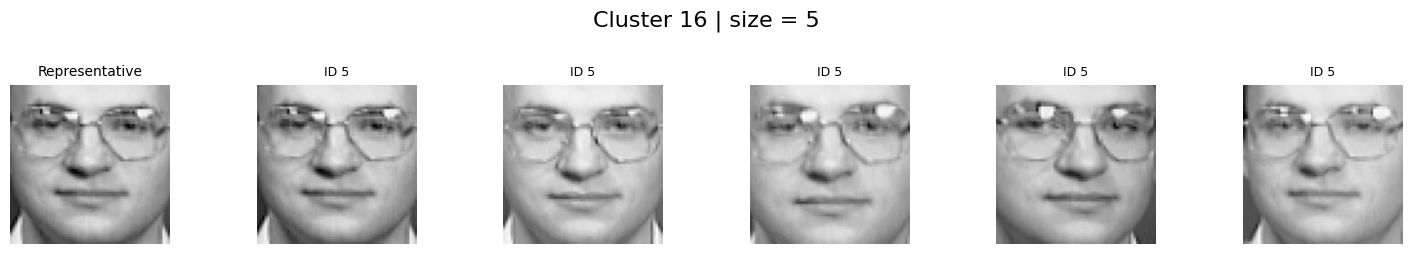

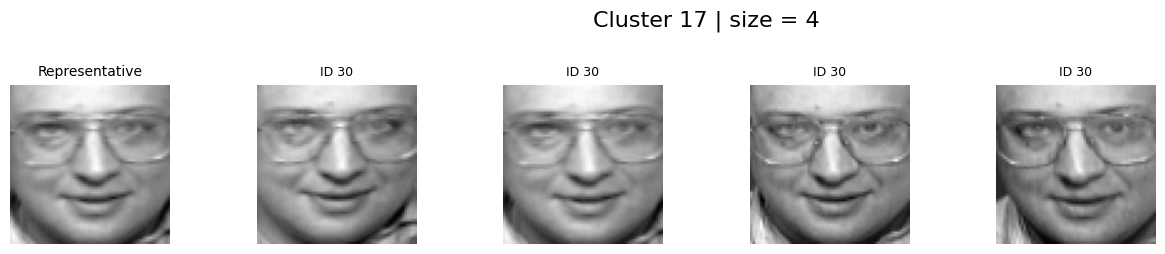

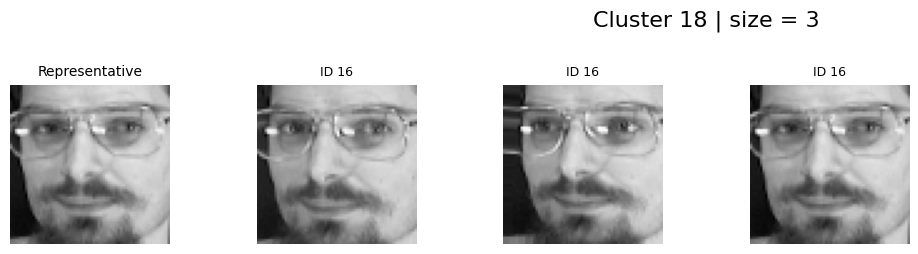

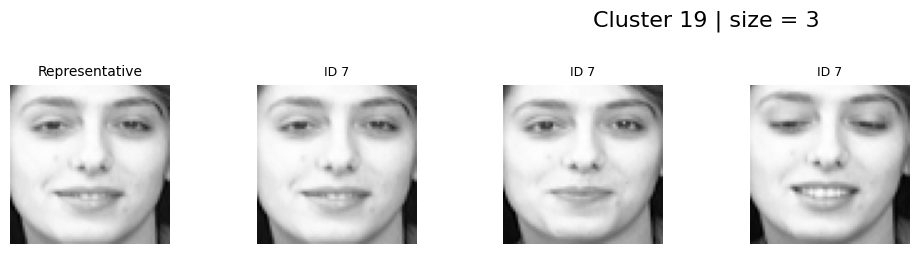

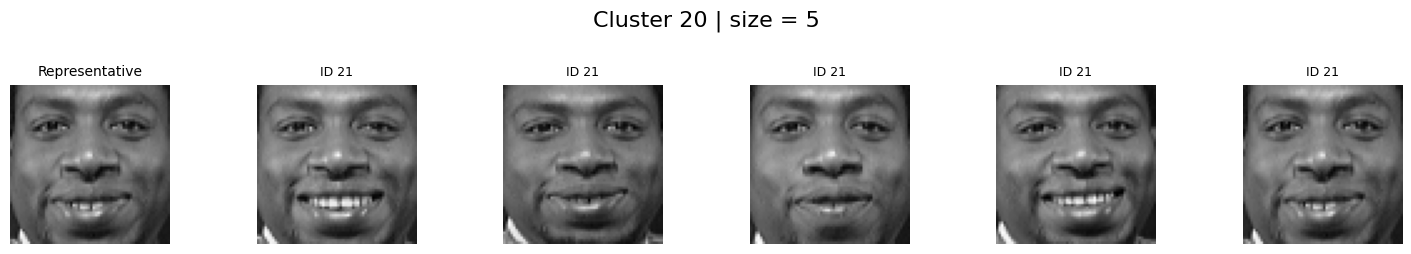

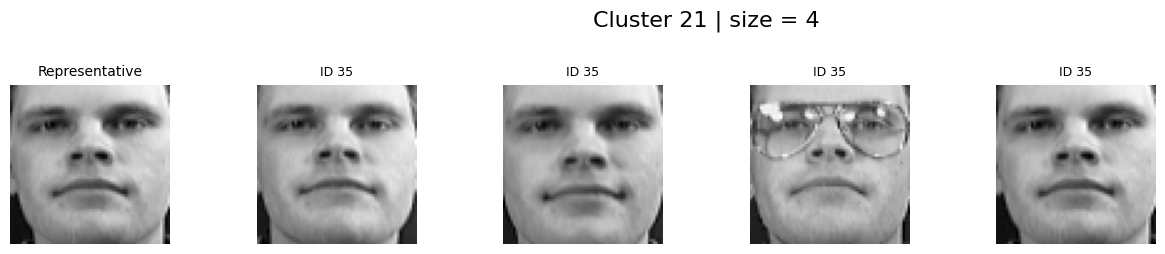

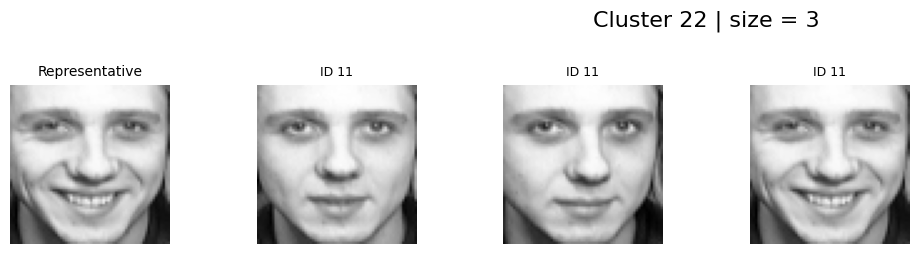

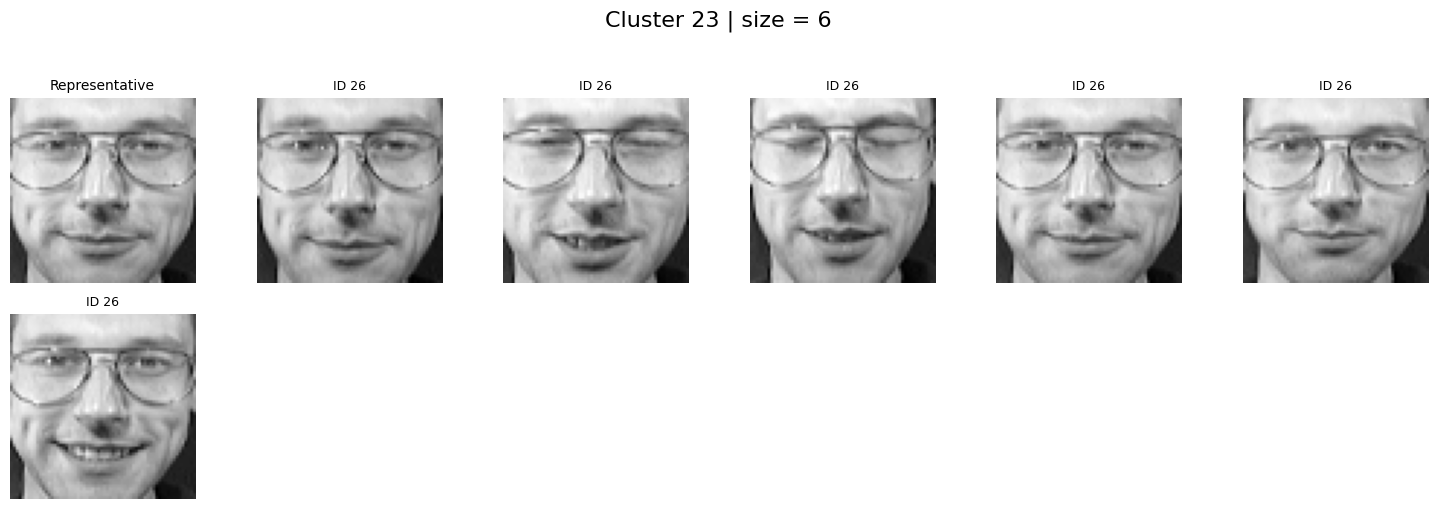

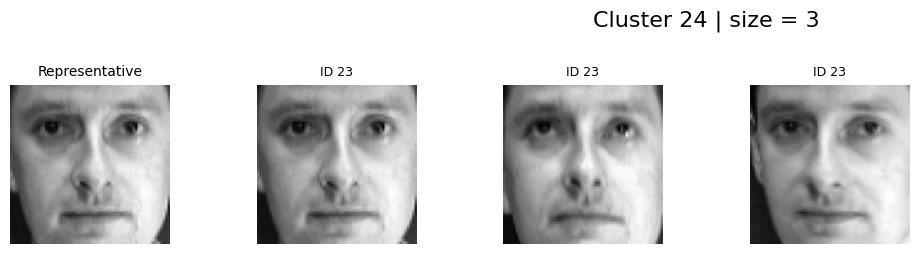

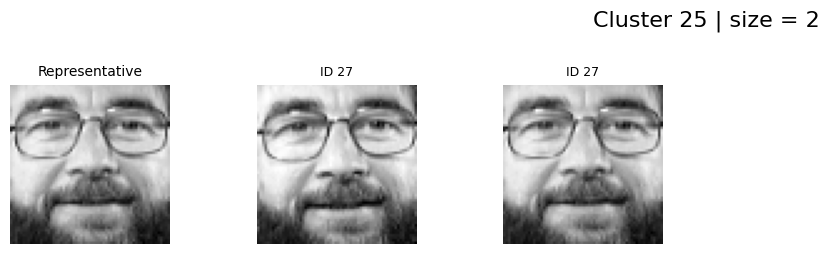

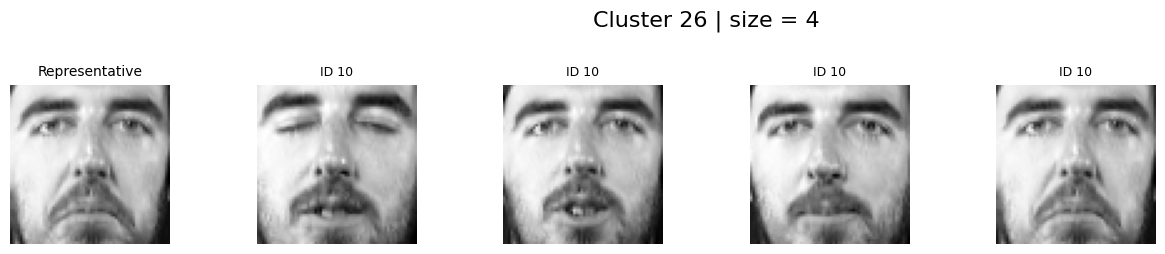

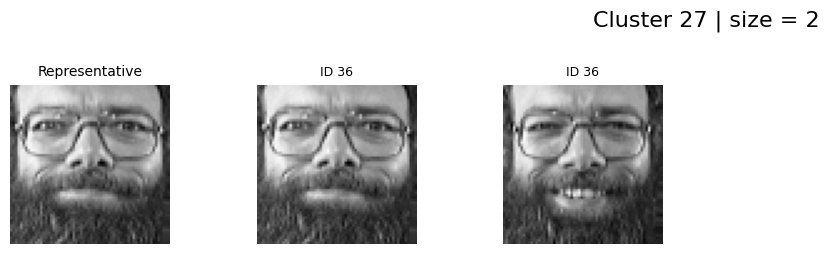

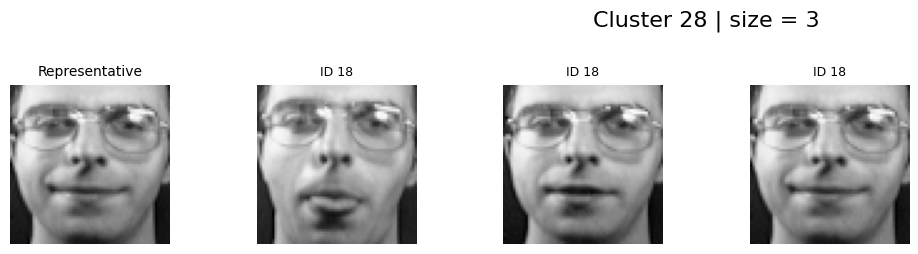

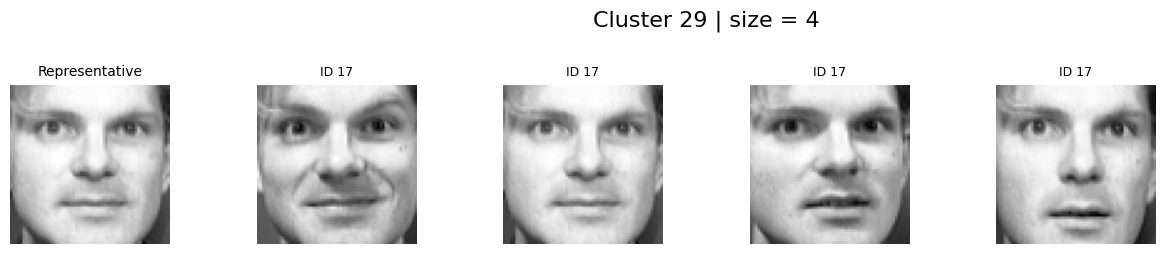

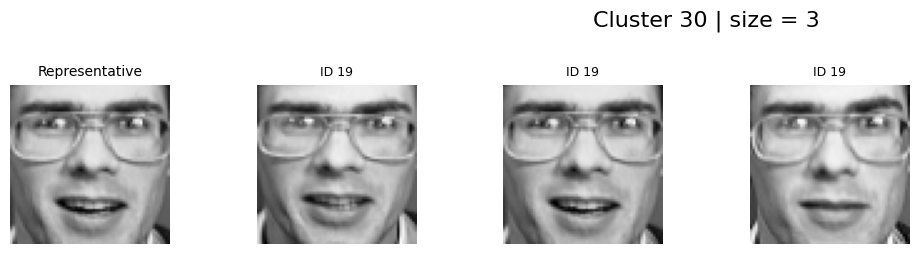

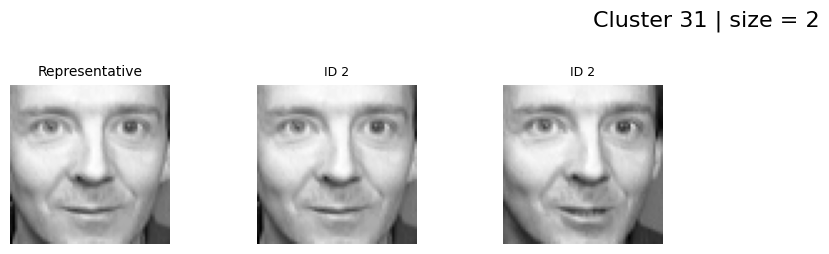

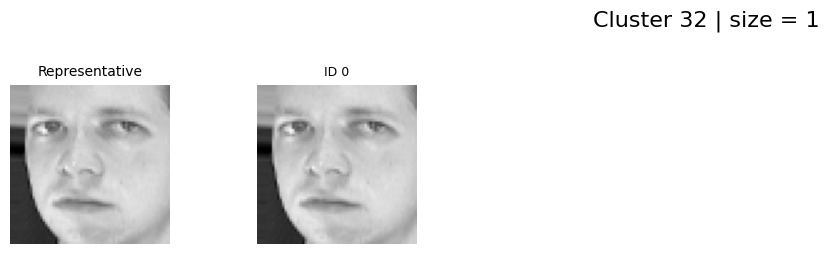

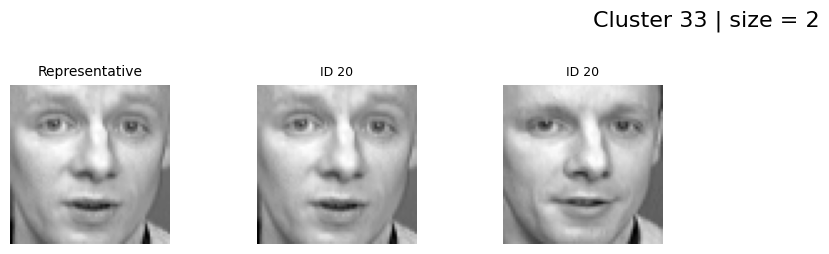

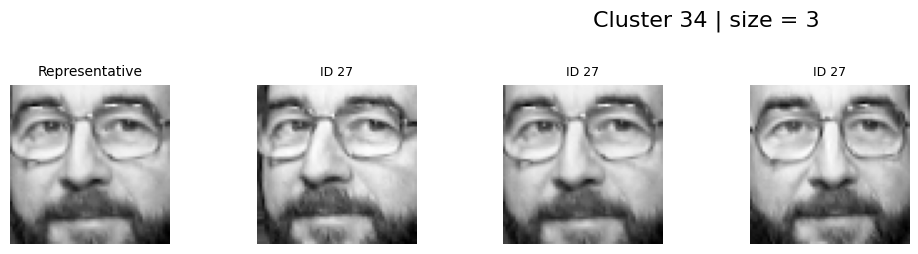

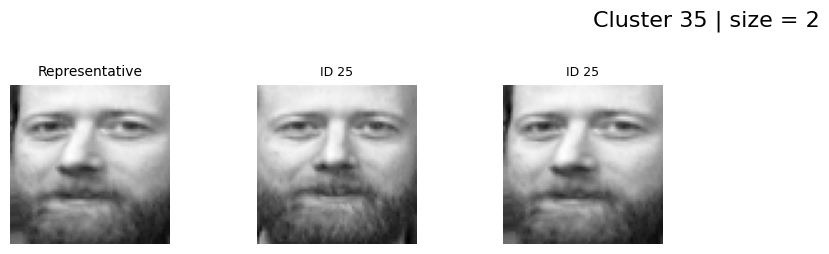

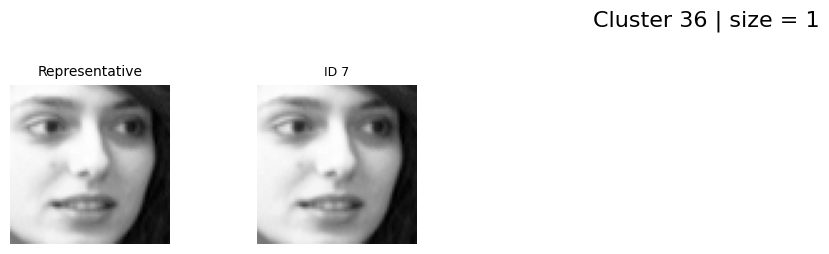

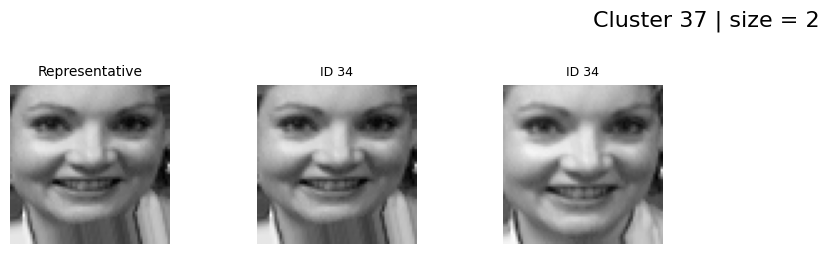

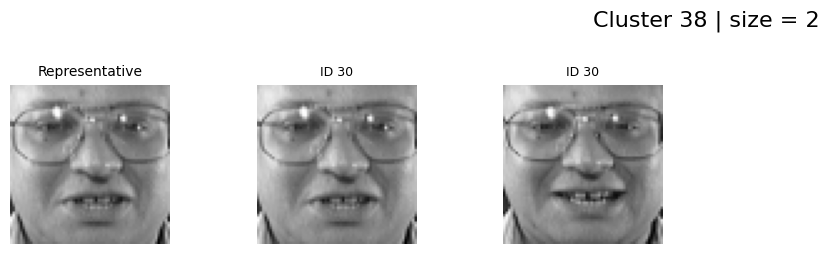

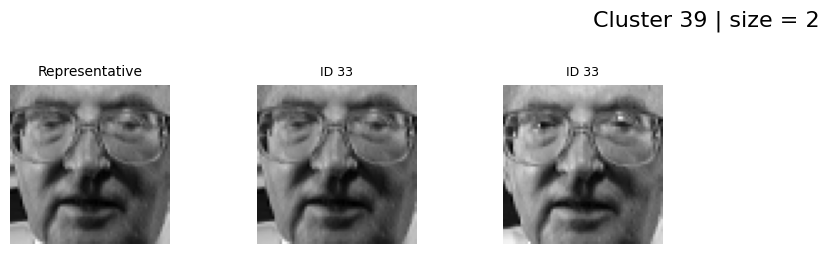

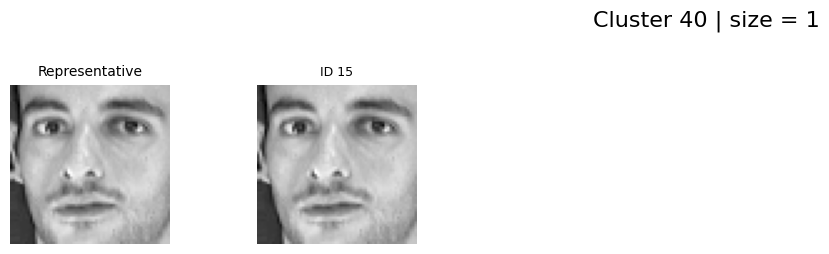

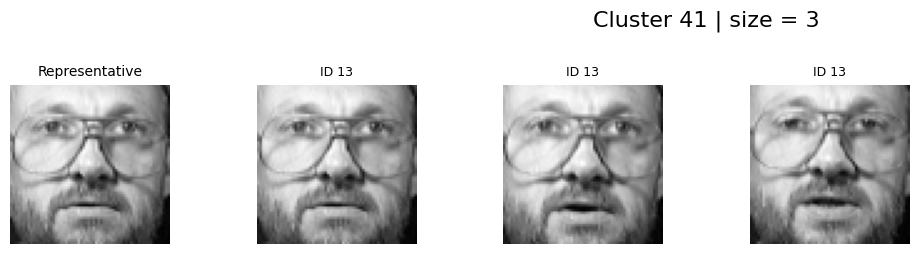

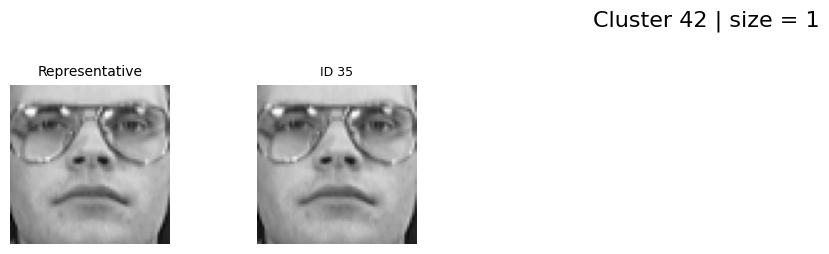

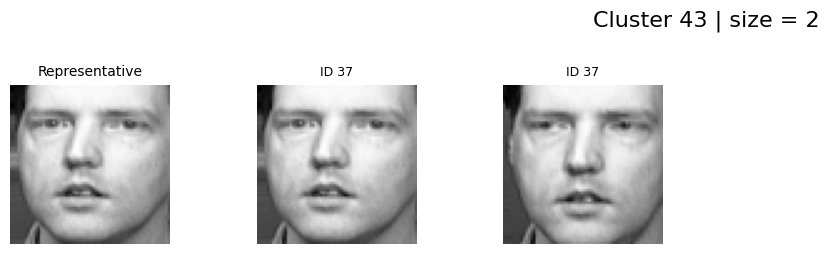

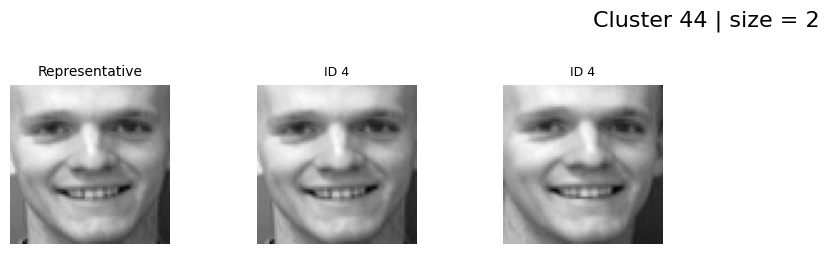

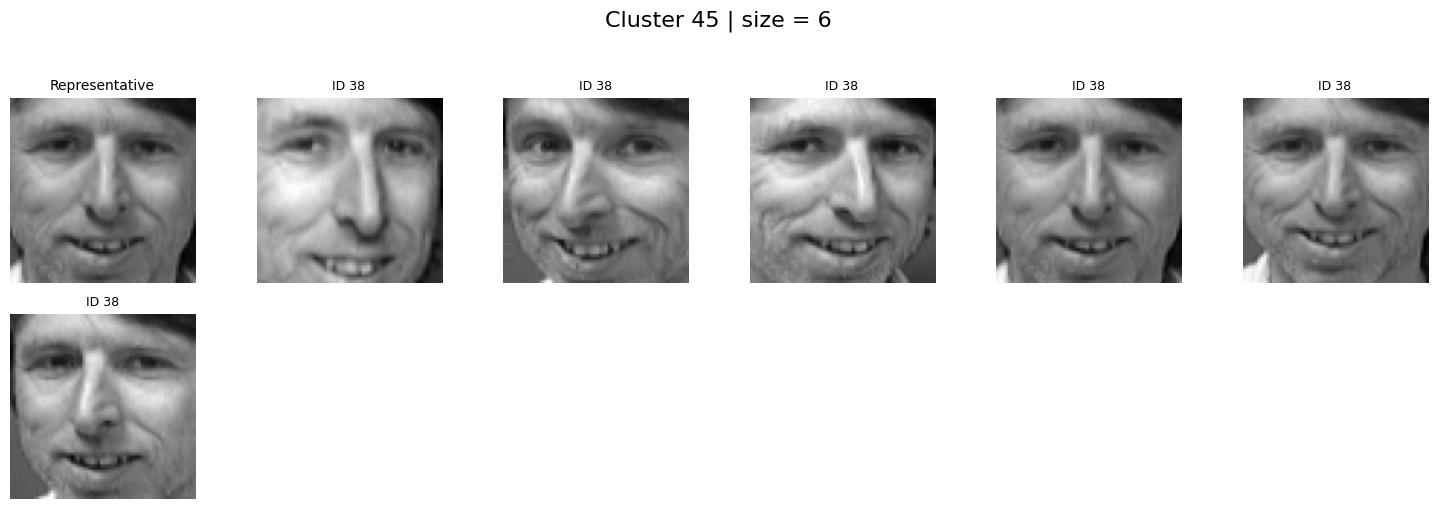

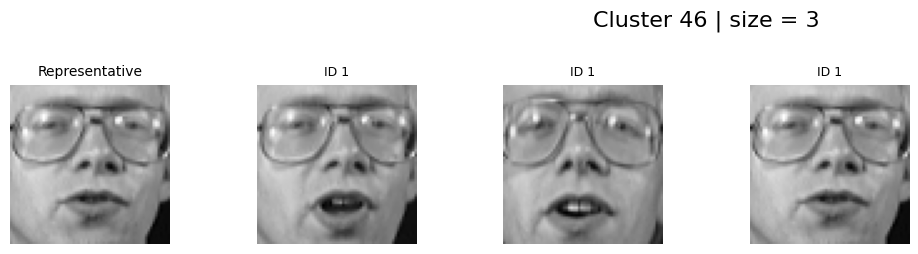

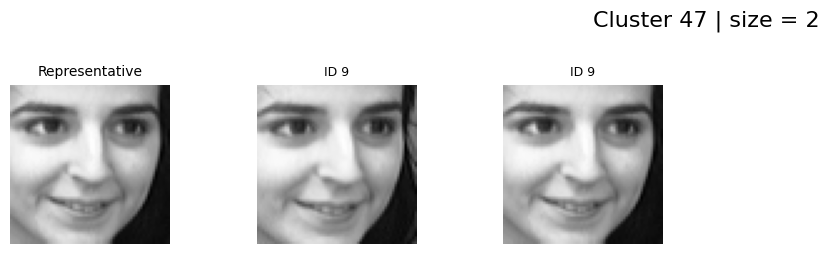

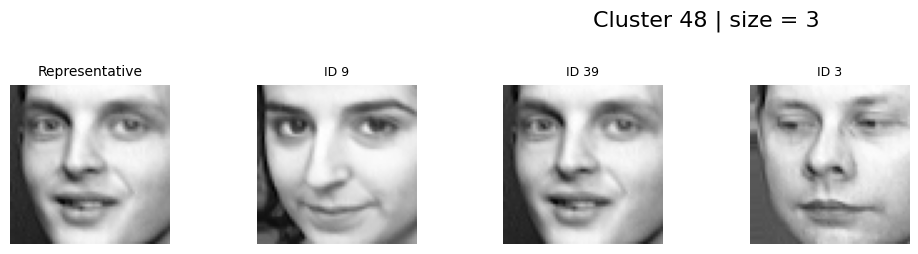

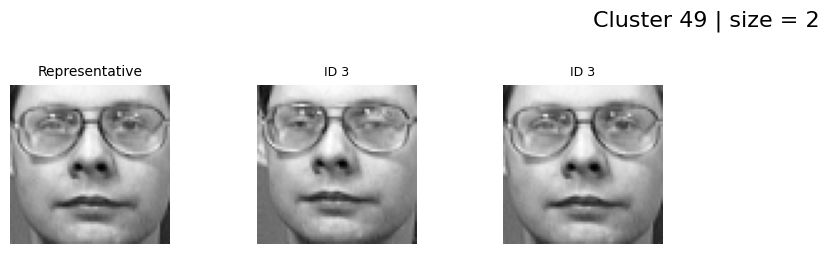

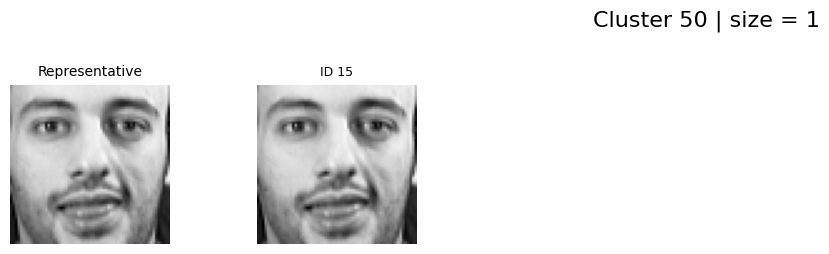

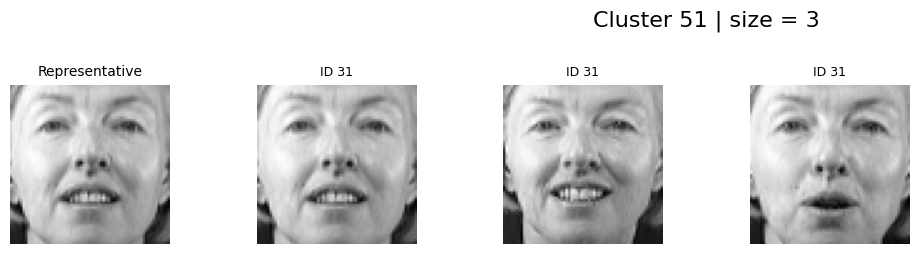

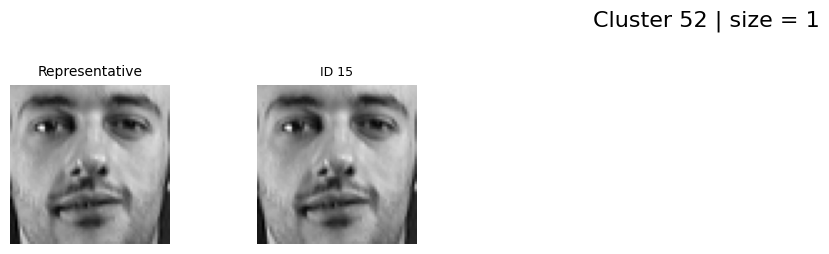

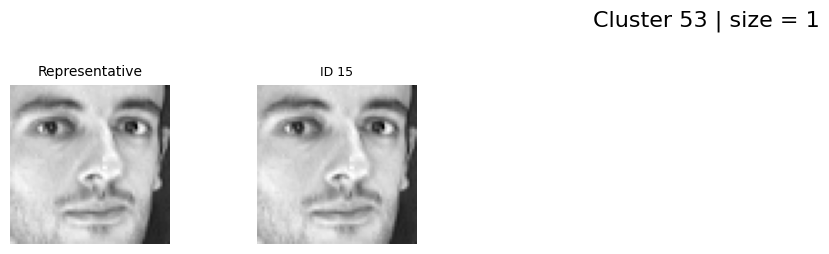

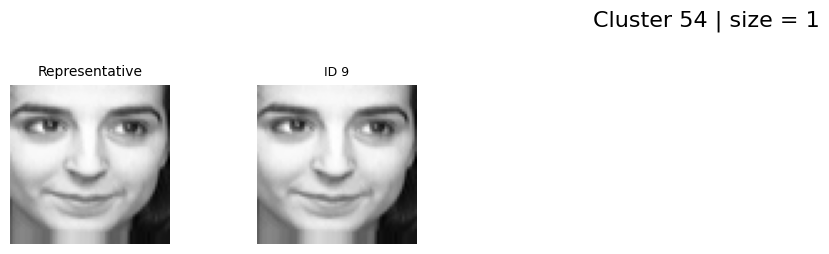

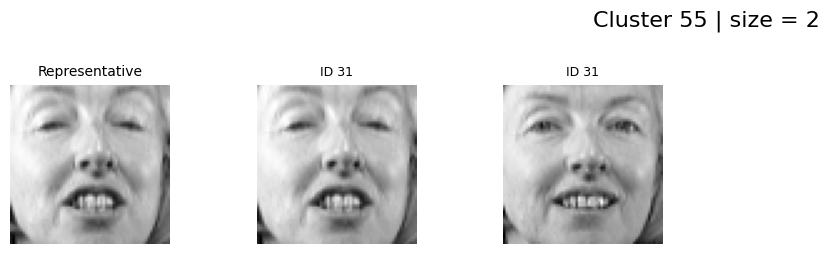

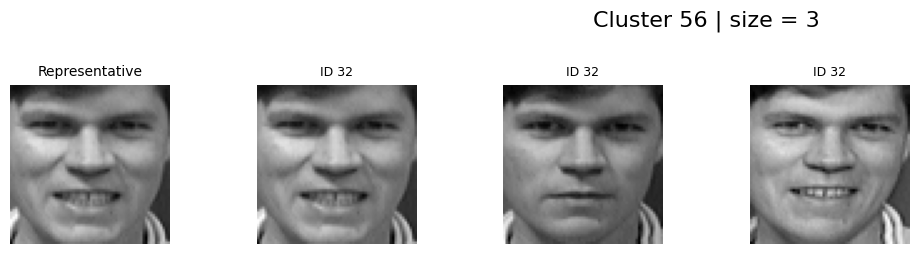

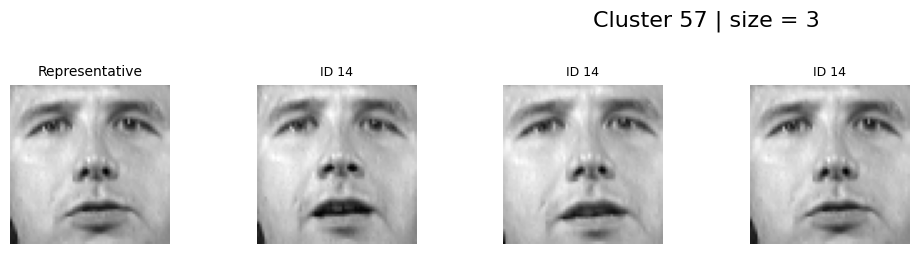

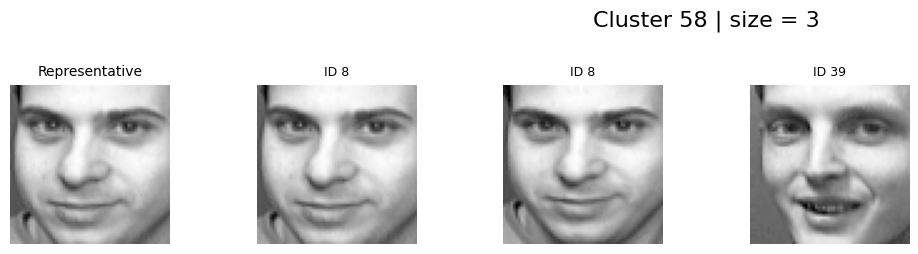

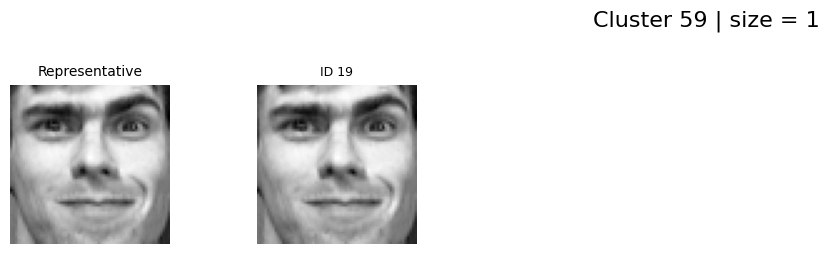

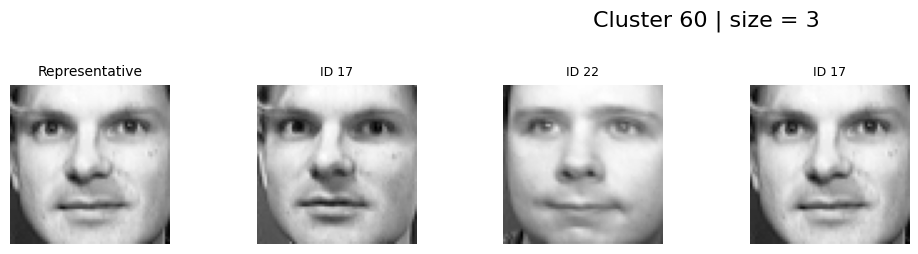

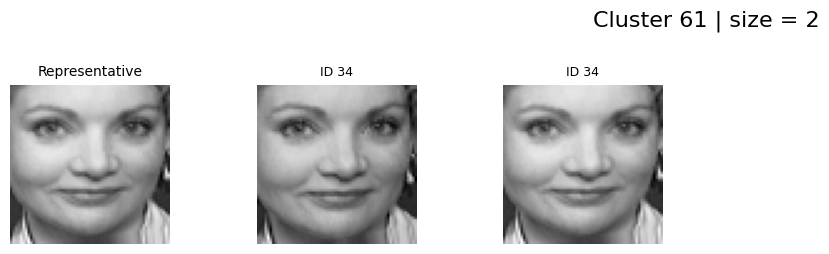

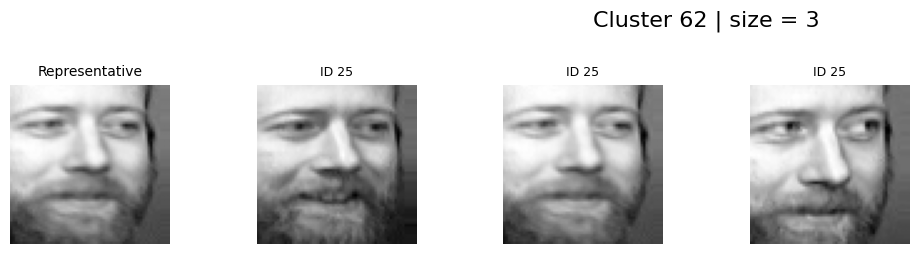

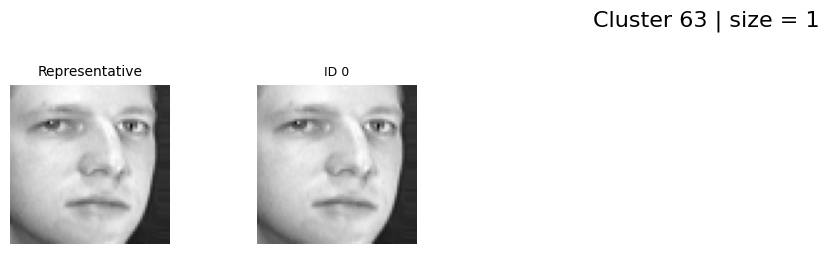

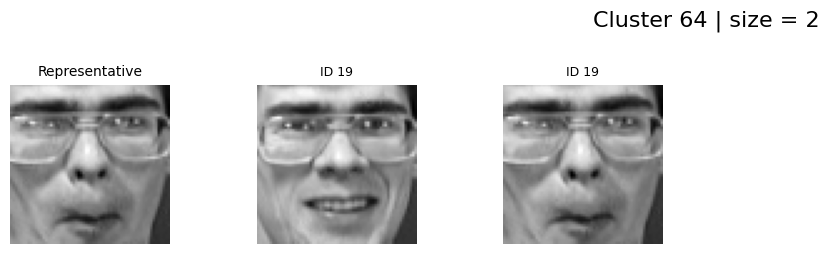

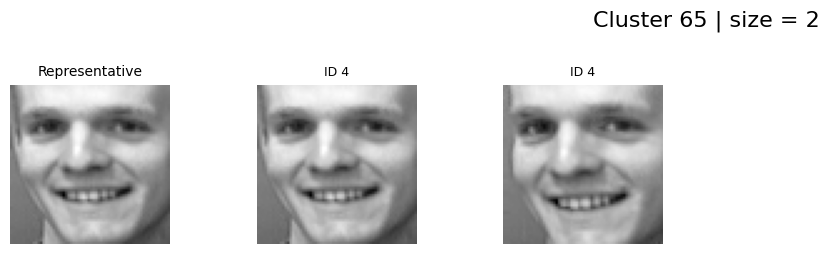

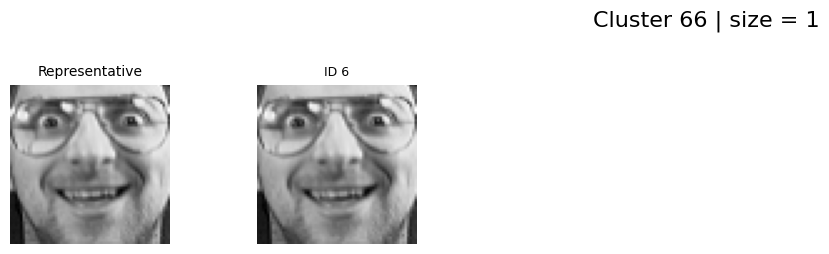

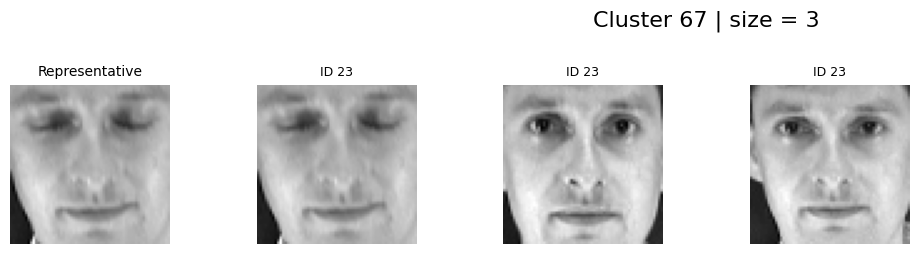

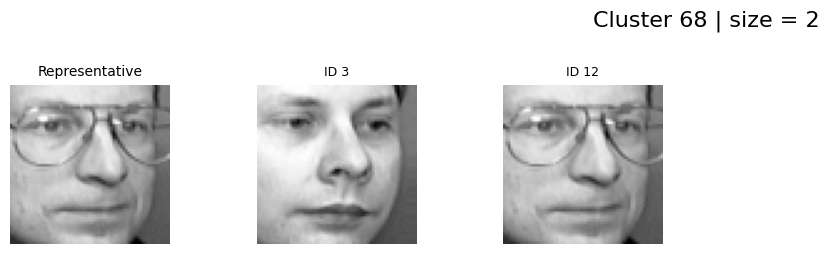

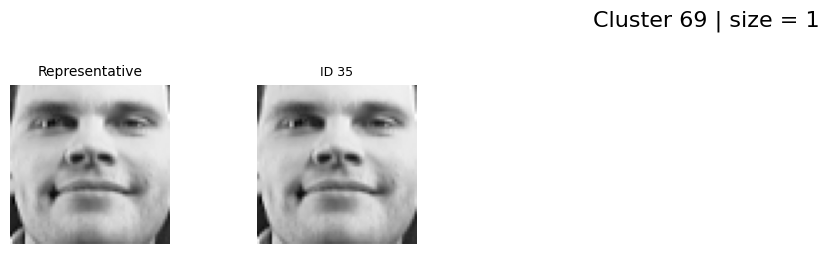

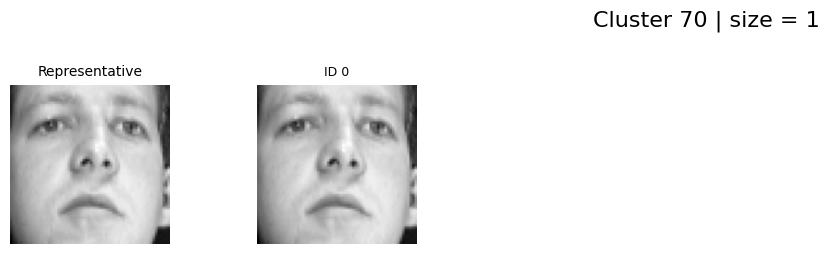

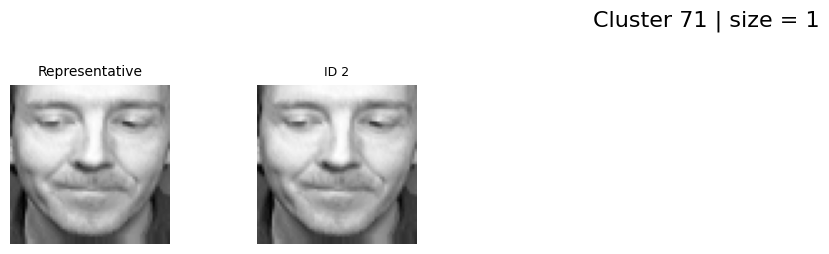

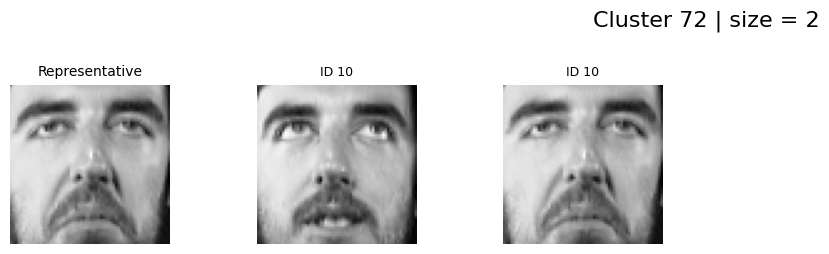

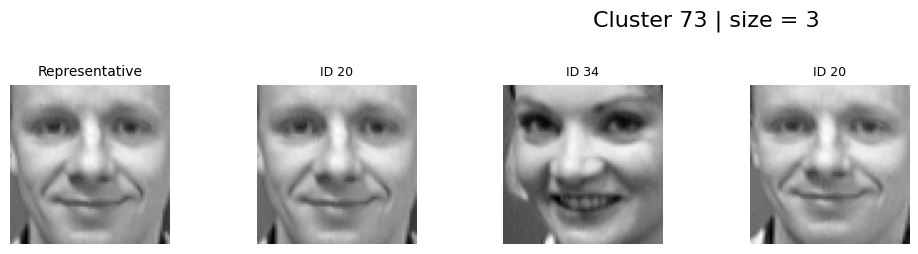

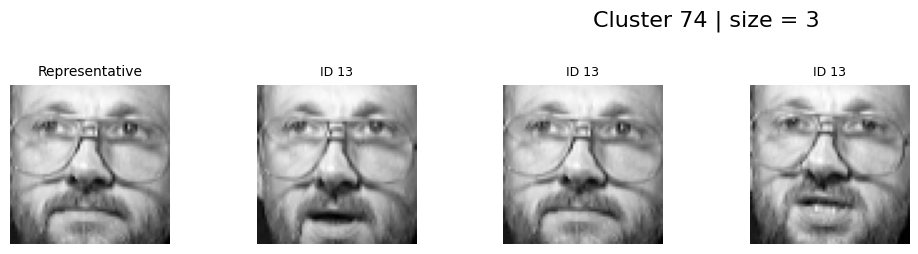

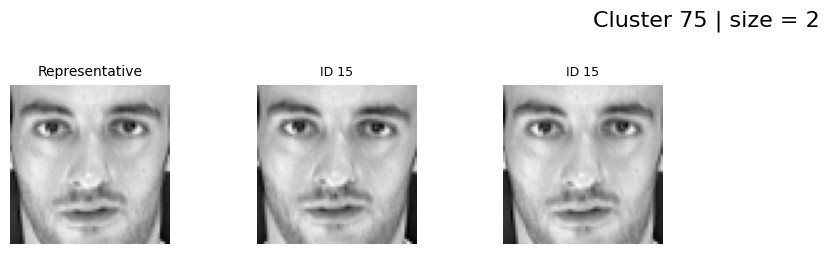

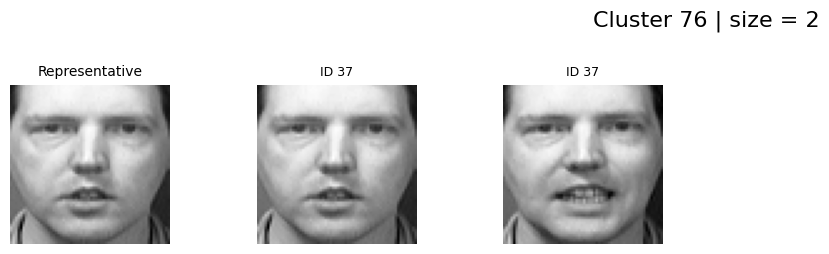

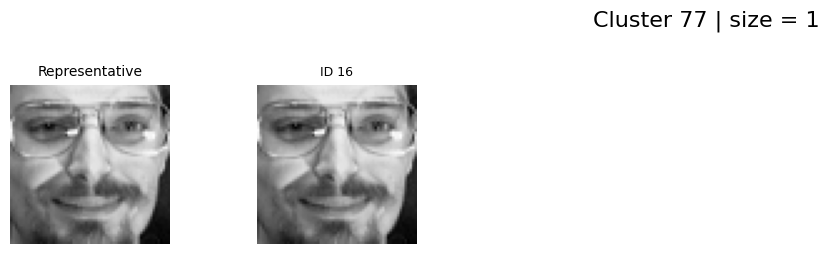

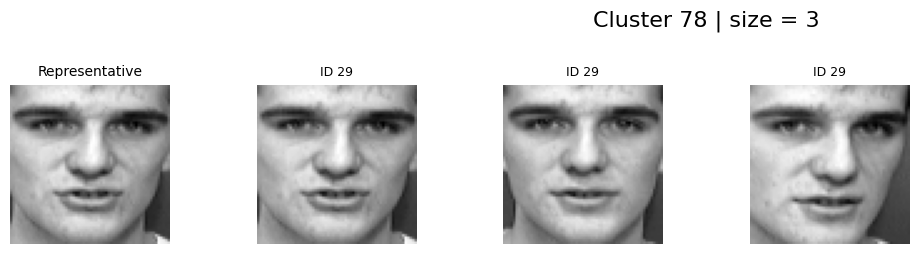

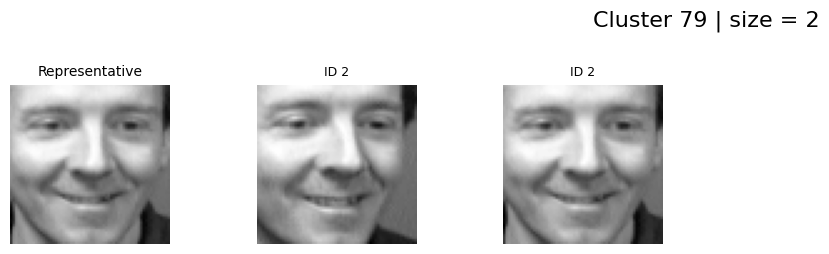

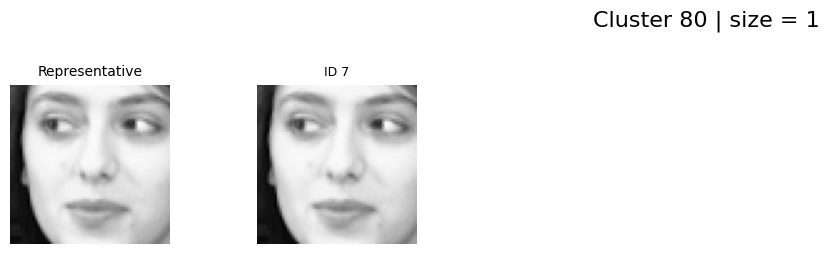

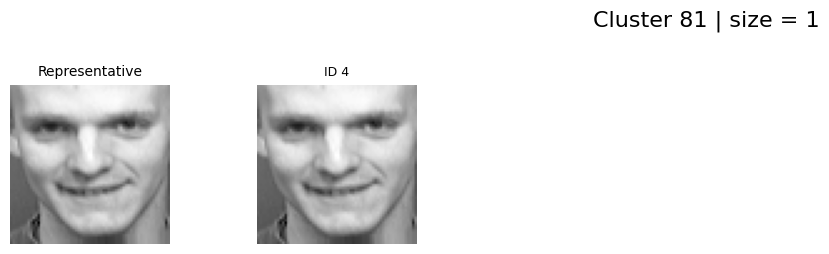

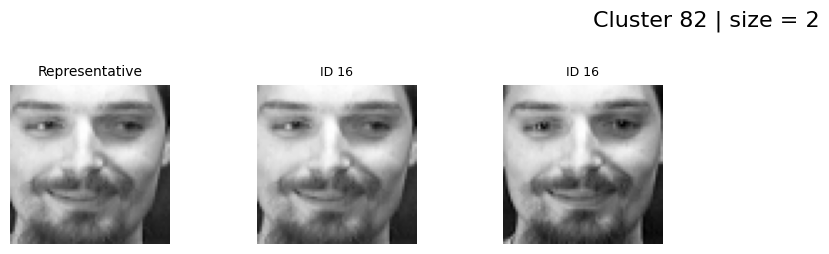

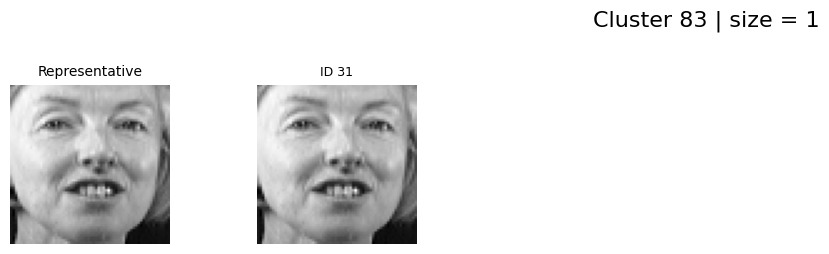

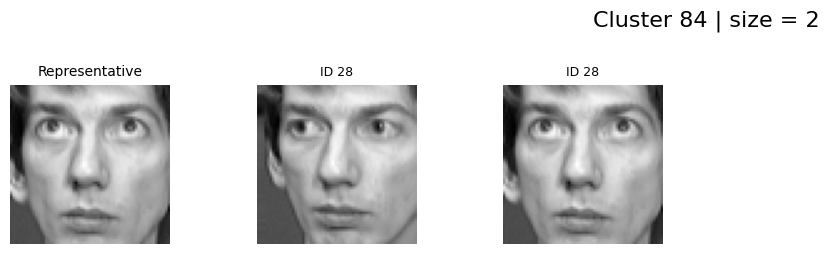

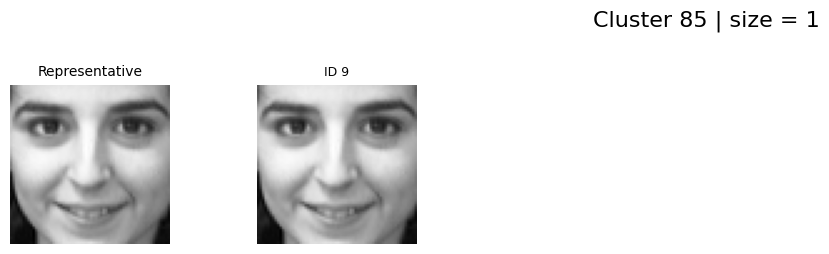

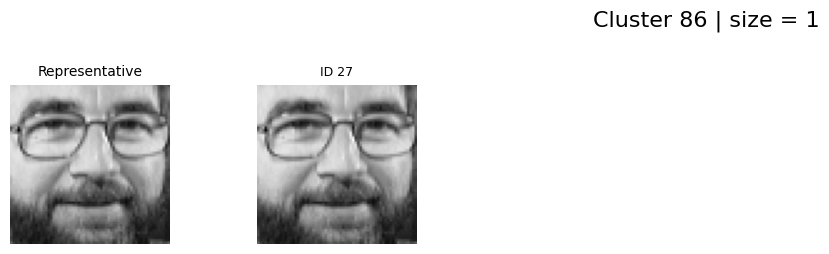

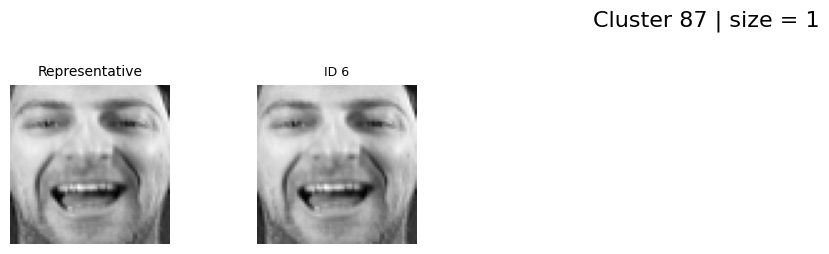

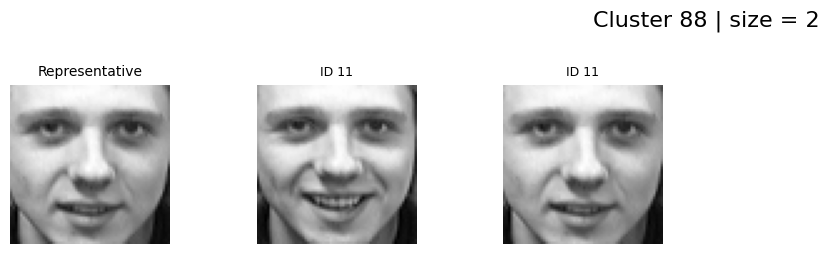

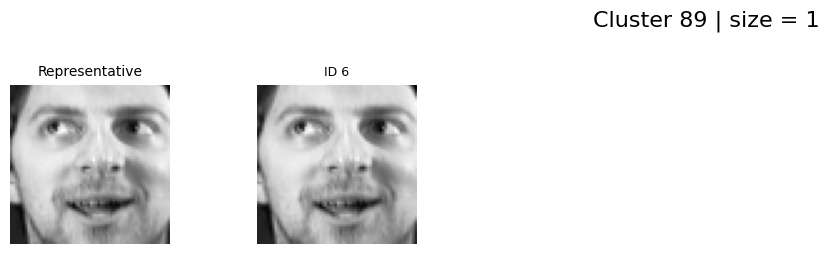

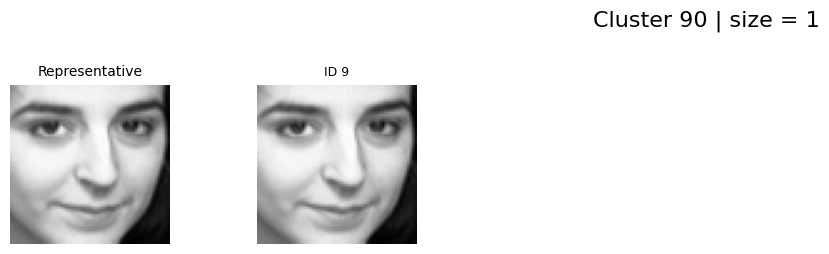

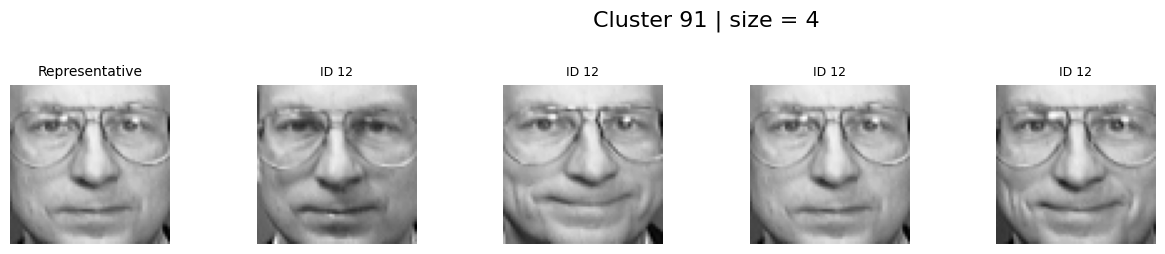

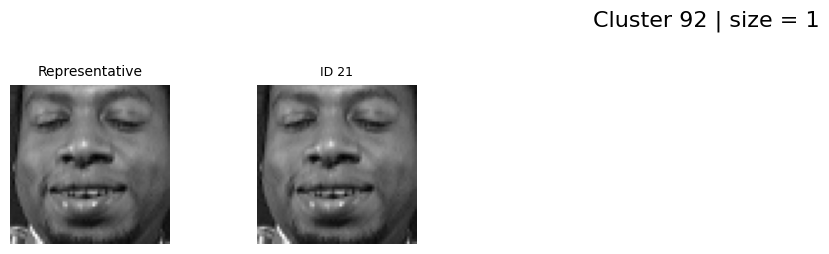

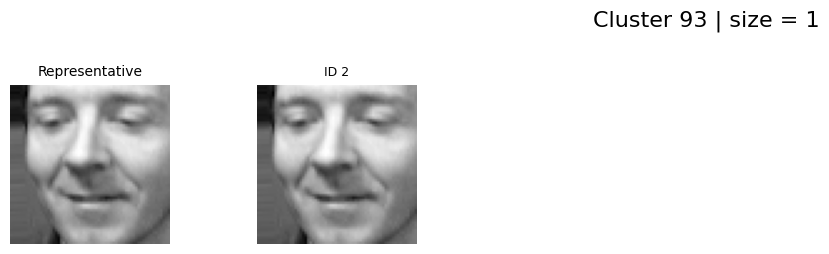

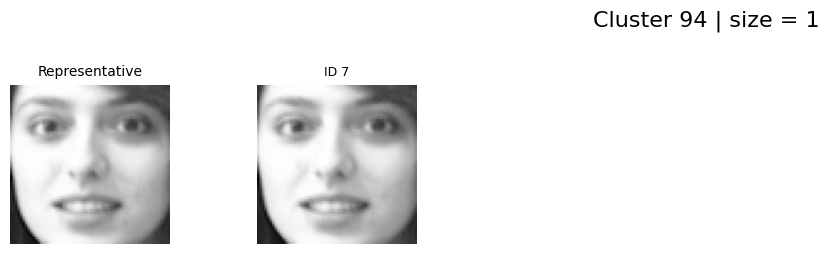

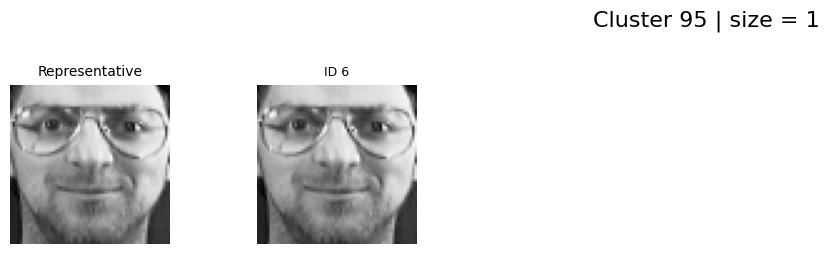

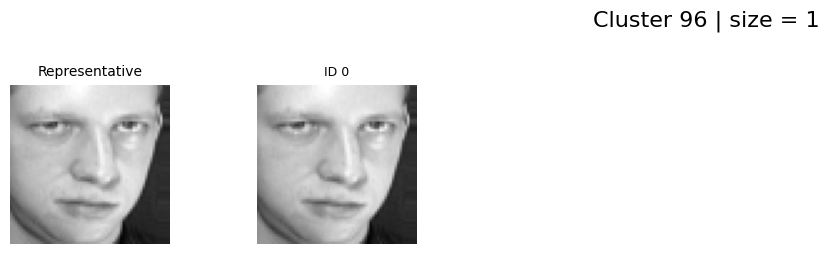

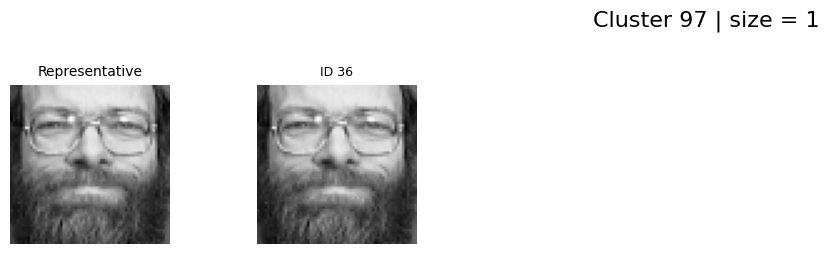

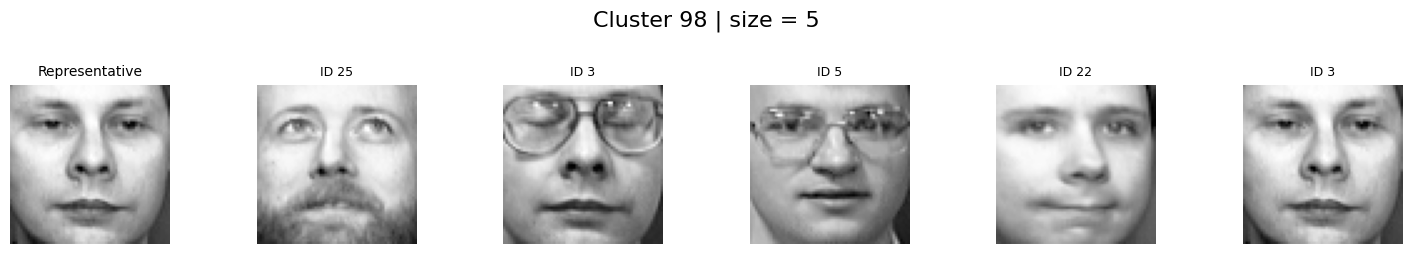

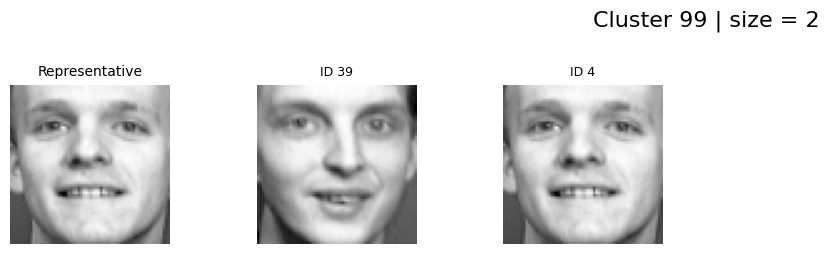

In [14]:
k = 100

kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
labels_train = kmeans.fit_predict(X_train)


# Distances from every training sample to every centroid: shape (n_samples, k)
X_train_dist = kmeans.transform(X_train)

# For each cluster (column), pick the sample (row) with the smallest distance
rep_idx = X_train_dist.argmin(axis=0)


EXAMPLES_PER_CLUSTER = 12   
N_COLS = 6                  # grid columns for examples
MAX_CLUSTERS_TO_SHOW = None 

cluster_ids = np.arange(k)
if MAX_CLUSTERS_TO_SHOW is not None:
    cluster_ids = cluster_ids[:MAX_CLUSTERS_TO_SHOW]

for cluster_id in cluster_ids:
    cluster_indices = np.where(labels_train == cluster_id)[0]
    cluster_size = len(cluster_indices)

    if cluster_size == 0:
        continue

    # Representative (closest to centroid)
    rep = rep_idx[cluster_id]

    # Sample example faces from this cluster
    n_show = min(cluster_size, EXAMPLES_PER_CLUSTER)
    sampled = np.random.choice(cluster_indices, size=n_show, replace=False)

    # Determine grid size: +1 for representative image
    total_images = 1 + n_show
    n_rows = int(np.ceil(total_images / N_COLS))

    plt.figure(figsize=(2.5 * N_COLS, 2.5 * n_rows))
    plt.suptitle(f"Cluster {cluster_id} | size = {cluster_size}", fontsize=16, y=1.02)

    # Plot representative face first
    plt.subplot(n_rows, N_COLS, 1)
    plt.imshow(images_train[rep], cmap="gray")
    plt.title("Representative", fontsize=10)
    plt.axis("off")

    # Plot example faces
    for i, idx in enumerate(sampled, start=2):
        plt.subplot(n_rows, N_COLS, i)
        plt.imshow(images_train[idx], cmap="gray")
        plt.title(f"ID {y_train[idx]}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## Step 7 — Visualizing Clusters (Conceptual Workflow Explanation)

### Goal of This Step

The purpose of this step is to **visually inspect the clusters produced by k-means** in order to understand what kind of structure the algorithm has discovered in the face images.

Rather than relying only on numerical metrics, we explicitly look at the images inside each cluster to interpret **what “similarity” means** in this context.

For each cluster, we display:
- One **representative face** (the image closest to the cluster centroid)
- A small set of **example faces** belonging to the cluster

---

### 1️⃣ Choosing the Number of Clusters

We start by fixing a value of `k`, the number of clusters chosen in the previous step based on inertia and silhouette analysis.

This determines how many groups k-means will partition the training images into.

---

### 2️⃣ Training k-means on the Training Set

k-means is trained using the flattened face images (`X_train`), where each image is represented as a vector of 4,096 pixel values.

After training, k-means has learned:
- `k` centroids (cluster centers)
- an assignment of each training image to one of these centroids

Each centroid represents the “average” of the images in that cluster in feature space.

---

### 3️⃣ Assigning Images to Clusters

Once k-means is fitted, every training image is assigned a cluster label indicating which centroid it is closest to.

This allows us to group images by cluster and analyze them one cluster at a time.

---

### 4️⃣ Computing Distances to Centroids

For each training image, we compute its distance to **every centroid**.

This produces a distance matrix where:
- each row corresponds to an image
- each column corresponds to a cluster centroid
- each value represents how far that image is from that centroid

This information is used to identify representative images.

---

### 5️⃣ Selecting a Representative Face per Cluster

A centroid itself is not a real image, but rather an abstract average.

To visualize clusters using real images, we select, for each cluster:
- the training image that is **closest to the centroid**

This image is called the **representative face** of the cluster and serves as a concrete example of what the cluster represents.

---

### 6️⃣ Visualizing Each Cluster

For each cluster, we perform the following steps:

1. Identify all images assigned to that cluster.
2. Display the representative face at the top.
3. Randomly sample a small number of additional images from the cluster.
4. Display these images in a grid for easy visual comparison.

Showing a limited number of examples keeps the visualization readable while still conveying the dominant visual patterns in the cluster.

---

### 7️⃣ Interpreting Similarity Within Clusters

When inspecting the clusters, similarity usually refers to:
- **Pose** (head orientation)
- **Lighting** (direction and intensity of illumination)
- **Facial expression**
- Sometimes background or contrast patterns

Importantly, clusters do **not necessarily correspond to identity**:
- Faces from different people may appear in the same cluster
- The same person may appear in multiple clusters

This is expected because k-means groups images based on pixel-level similarity, not semantic identity.

---

### Key Takeaway

Visualizing clusters using representative and example faces allows us to interpret what k-means has learned, revealing that clusters capture shared visual appearance patterns (such as pose and lighting) rather than person identity in high-dimensional face image data.

---
---
### Step 8️⃣ Baseline Classifier (No Dimensionality Reduction

In [15]:
baseline_clf = LogisticRegression(
    max_iter=10000, 
    multi_class="auto", 
    solver="lbfgs", 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

baseline_clf.fit(X_train, y_train)

y_val_pred = baseline_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Baseline validation accuracy (no dimensionality reduction):")
print(f"{val_accuracy:.4f}")
print(baseline_clf.score(X_test, y_test)) 

Baseline validation accuracy (no dimensionality reduction):
0.9583
0.96875


The baseline Logistic Regression classifier achieves high validation accuracy on the Olivetti Faces dataset. This is expected due to the controlled nature of the dataset and the high-dimensional pixel representation, which allows linear models to separate identities effectively. However, this performance may reflect dataset-specific correlations rather than robust feature learning, motivating the use of clustering and dimensionality reduction techniques to improve generalization and interpretability.

### Step 9️⃣ k-means as Dimensionality Reduction

In [16]:
k = 100

kmeans = KMeans(
    n_clusters=k, 
    random_state=RANDOM_STATE, 
    n_init=10
)

kmeans.fit(X_train)

# transform datasets 
X_train_k = kmeans.transform(X_train)
X_val_k = kmeans.transform(X_val)

print("Orginal feature shape", X_train.shape)
print("Transformed feature shape", X_train_k.shape) 

Orginal feature shape (240, 4096)
Transformed feature shape (240, 100)


 - X_train_k has 100 features instead of 4096
 - Each feature is the distance to one centroid

In [17]:
clf_kmeans = LogisticRegression(
    max_iter=10000, 
    multi_class="auto", 
    solver="lbfgs", 
    n_jobs=-1, 
    random_state=RANDOM_STATE 
)

clf_kmeans.fit(X_train_k, y_train)

y_pred_k = clf_kmeans.predict(X_val_k)
val_accuracy_k = accuracy_score(y_val, y_pred_k)


print("Validation accuracy (k-means features):")
print(f"{val_accuracy_k:.4f}") 

Validation accuracy (k-means features):
0.9375


Using k-means as a feature transform reduced the dimensionality by a factor of 40 while preserving most of the classification performance, confirming the trade-offs discussed in Chapter 8 

### Step 🔟 Search for the Best Number of Clusters

In [33]:
k_values = list(range(40, 170, 5))
val_accuracies = [] 

for k in k_values: 
    kmeans = KMeans(
        n_clusters=k, 
        random_state=RANDOM_STATE
    )

    kmeans.fit(X_train)

    X_train_k_local = kmeans.transform(X_train)
    X_val_k_local = kmeans.transform(X_val)

    clf = LogisticRegression(
        max_iter=5000, 
        random_state=RANDOM_STATE
    )
    clf.fit(X_train_k_local, y_train)

    val_pred = clf.predict(X_val_k_local)
    acc = accuracy_score(y_val, val_pred)

    val_accuracies.append(acc) 
    print(f"k={k:3d} | validation accuracy={acc:.4f}")

k= 40 | validation accuracy=0.8854
k= 45 | validation accuracy=0.8854
k= 50 | validation accuracy=0.8854
k= 55 | validation accuracy=0.9062
k= 60 | validation accuracy=0.8958
k= 65 | validation accuracy=0.8958
k= 70 | validation accuracy=0.8958
k= 75 | validation accuracy=0.8958
k= 80 | validation accuracy=0.9062
k= 85 | validation accuracy=0.9062
k= 90 | validation accuracy=0.9062
k= 95 | validation accuracy=0.9375
k=100 | validation accuracy=0.9167
k=105 | validation accuracy=0.9375
k=110 | validation accuracy=0.9167
k=115 | validation accuracy=0.9479
k=120 | validation accuracy=0.9375
k=125 | validation accuracy=0.9271
k=130 | validation accuracy=0.9062
k=135 | validation accuracy=0.9167
k=140 | validation accuracy=0.9167
k=145 | validation accuracy=0.9167
k=150 | validation accuracy=0.9479
k=155 | validation accuracy=0.9479
k=160 | validation accuracy=0.9479
k=165 | validation accuracy=0.9375


In [34]:
    best_k = k_values[np.argmax(val_accuracies)]
    best_acc = max(val_accuracies)

    print(f"\nBest k: {best_k}")
    print(f"Best validation accuracy: {best_acc:.4f}") # :.4f -> 4 decimals (e.g.  0.9479)  


Best k: 115
Best validation accuracy: 0.9479


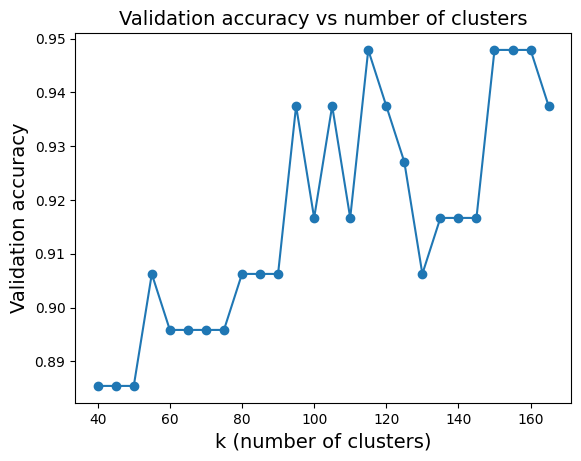

In [35]:
plt.figure()
plt.plot(k_values, val_accuracies, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy vs number of clusters")
plt.show() 

Interpretation in plain terms: 

	•	Using k-means with 115 clusters as a feature transformer
	•	Then training Logistic Regression on distances-to-centroids
	•	Gives ~94.8% validation accuracy

That is:

	•	Very close to your baseline (~95%)
	•	With 115 features instead of 4096
	•	A dimensionality reduction of ~35×

### Step 1️⃣1️⃣ Append Reduced Features to Original Features

So far we tested three representations:

	1.	Original features only: 
    
    	•	4096 raw pixel values
    	•	Accuracy ≈ 95%
        
	2.	k-means features only: 
    
    	•	Distances to centroids (k = 115)
    	•	Accuracy ≈ 94.8%

In [39]:
best_kmeans = KMeans(
    n_clusters=best_k, 
    random_state=RANDOM_STATE, 
    n_init=10
)

best_kmeans.fit(X_train) 

X_train_k = best_kmeans.transform(X_train)
X_val_k = best_kmeans.transform(X_val)
X_test_k = best_kmeans.transform(X_test) 

print(X_train_k.shape)
print(X_val_k.shape)
print(X_test_k.shape) 

(240, 115)
(96, 115)
(64, 115)


In [44]:
X_train_aug = np.hstack([X_train, X_train_k])
X_val_aug = np.hstack([X_val, X_val_k])
X_test_aug = np.hstack([X_test, X_test_k]) 

# It creates a new feature matrix by concatenating two different feature representations of the same samples 
# When you concatenate them, the classifier sees both perspectives.

In [45]:
clf_aug = LogisticRegression(
    max_iter=10000, 
    random_state=RANDOM_STATE
)

clf_aug.fit(X_train_aug, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [47]:
val_pred_aug = clf_aug.predict(X_val_aug)
val_acc_aug = accuracy_score(y_val, val_pred_aug)

print(f"Validation accuracy (augmented features): {val_acc_aug:.4f}") 

Validation accuracy (augmented features): 0.9583


Combining raw pixel features with k-means distance features yields a richer representation that improves classification performance, confirming the practical value of unsupervised feature learning 

### Step 1️⃣2️⃣ PCA (99% Variance Preservation) 

In [55]:
pca = PCA(
    n_components=0.99,
    random_state=RANDOM_STATE
)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print("Original dimensionality:", X_train.shape[1])
print("Reduced dimensionality:", X_train_pca.shape[1])
print("Explained variance ratio:", pca.explained_variance_ratio_.sum()) 

Original dimensionality: 4096
Reduced dimensionality: 178
Explained variance ratio: 0.99017066


Applying PCA with 99% variance preservation reduced the dimensionality of the Olivetti faces dataset from 4096 to 178 components, while retaining over 99% of the original variance. This confirms that face images are highly redundant and lie in a much lower-dimensional subspace, making PCA an effective preprocessing step before training Gaussian mixture models 

### Step 1️⃣3️⃣ Train a Gaussian Mixture Model (GMM) 

#### Conceptual Explanation

A Gaussian Mixture Model (GMM) is a **probabilistic clustering** and **density estimation model.**
Instead of assigning each point to exactly one cluster as k-means does, a GMM models the data as a mixture of multiple Gaussian distributions.

Each component learns:

	•	a mean (center of the cluster)
	•	a covariance matrix (shape, orientation, spread)
	•	a weight (how common this component is)

Why we train the GMM in PCA space

Training a GMM directly on raw images 4096 dimensions would be:

	•	extremely slow
	•	numerically unstable
	•	prone to overfitting

After PCA 178 dimensions:

	•	features are decorrelated
	•	noise is reduced
	•	covariance estimation becomes feasible

In [56]:
n_components = 40

gmm = GaussianMixture(
    n_components=n_components, 
    covariance_type="full", 
    n_init=10, 
    random_state=RANDOM_STATE
)

gmm.fit(X_train_pca)

print("GMM converged:", gmm.converged_)
print("Number of EM iterations:", gmm.n_iter_) 

GMM converged: True
Number of EM iterations: 2


In [57]:
# Learned patters 

print("Weights shape:", gmm.weights_.shape)
print("Means shape:", gmm.means_.shape)
print("Covariances shape:", gmm.covariances_.shape) 

Weights shape: (40,)
Means shape: (40, 178)
Covariances shape: (40, 178, 178)


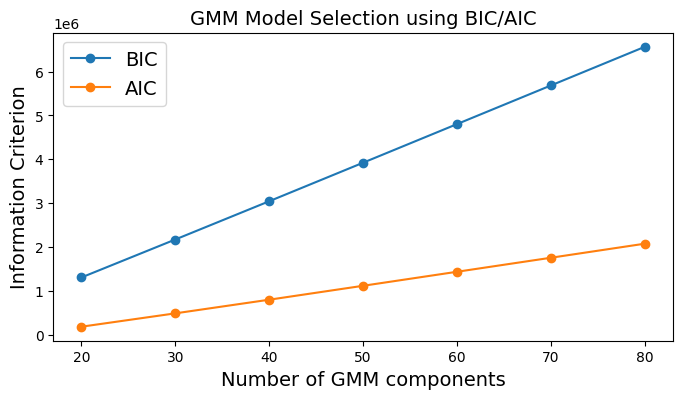

In [58]:
n_components_range = range(20, 81, 10)
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type="full",
        n_init=5,
        random_state=RANDOM_STATE
    )
    gmm.fit(X_train_pca)

    bics.append(gmm.bic(X_train_pca))
    aics.append(gmm.aic(X_train_pca))

plt.figure(figsize=(8, 4))
plt.plot(n_components_range, bics, label="BIC", marker="o")
plt.plot(n_components_range, aics, label="AIC", marker="o")
plt.xlabel("Number of GMM components")
plt.ylabel("Information Criterion")
plt.title("GMM Model Selection using BIC/AIC")
plt.legend()
plt.show()

The BIC and AIC curves increase monotonically with the number of components, indicating that simpler Gaussian mixture models are preferred from an information-theoretic perspective. This reflects the high dimensionality of the PCA space, where each additional component significantly increases model complexity. In this work, we retain a moderate number of components to balance model simplicity and representational richness 

### Step 1️⃣4️⃣ Generate New Faces 

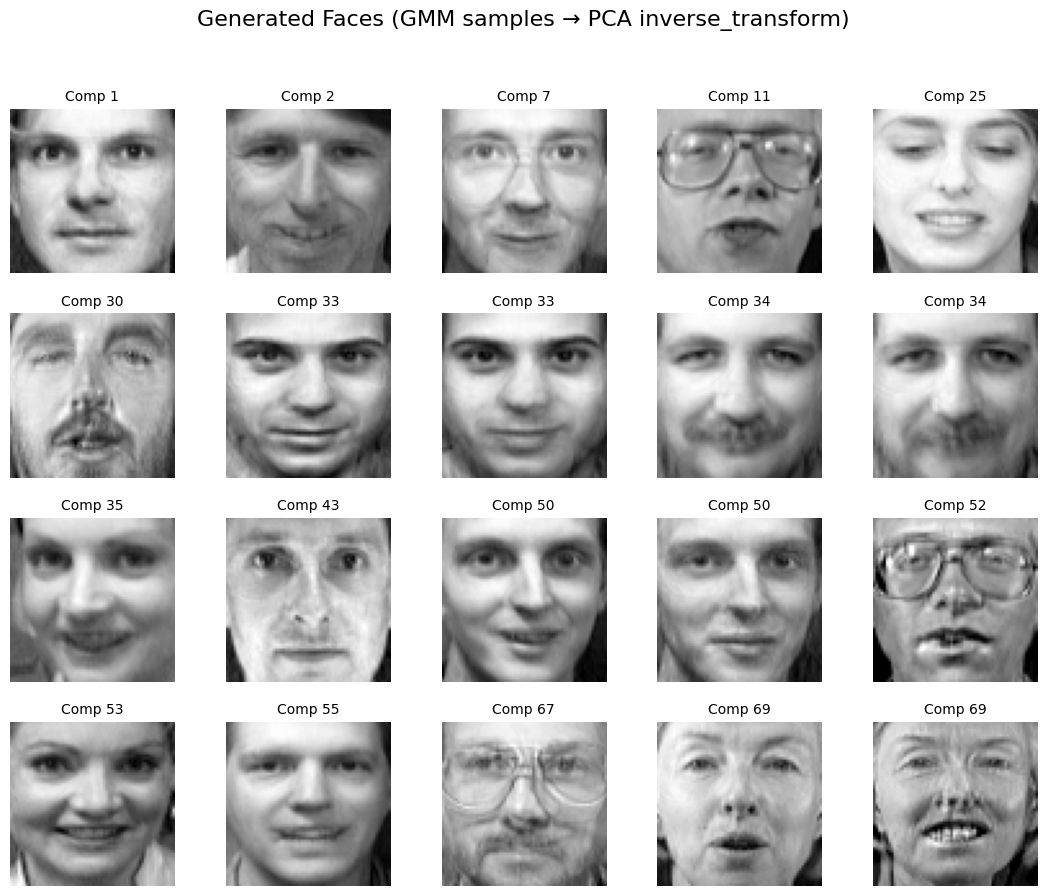

In [61]:
# -----------------------------
# 1) Sample new points from the GMM (in PCA space)
# -----------------------------
n_samples = 20
X_new_pca, y_new_comp = gmm.sample(n_samples)  # X_new_pca: (n_samples, 178)

# -----------------------------
# 2) Convert back to original pixel space (4096 dims)
# -----------------------------
X_new = pca.inverse_transform(X_new_pca)       # shape: (n_samples, 4096)
images_new = X_new.reshape(-1, 64, 64)

# Keep pixel values in valid range (dataset uses [0, 1])
images_new = np.clip(images_new, 0, 1)

# -----------------------------
# 3) Visualize generated faces in a grid
# -----------------------------
n_cols = 5
n_rows = (n_samples - 1) // n_cols + 1

plt.figure(figsize=(2.2 * n_cols, 2.2 * n_rows))
plt.suptitle("Generated Faces (GMM samples → PCA inverse_transform)", fontsize=16, y=1.02)

for i in range(n_samples):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(images_new[i], cmap="gray")
    plt.title(f"Comp {y_new_comp[i]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [1]:
# test